# Step 4: Model Exploration and Optimization

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path

#import label encoding
from sklearn.preprocessing import LabelEncoder

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Activation, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Sklearn tools for SVM model building
from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Custom functions (this works, finally)
from pyTools.utils import *
from pyTools.preprocess import *
from pyTools.predict import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [2]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/classify_by_type")

In [3]:
data = data_from_dir(data_dir)

Found 13766 files belonging to 16 classes.


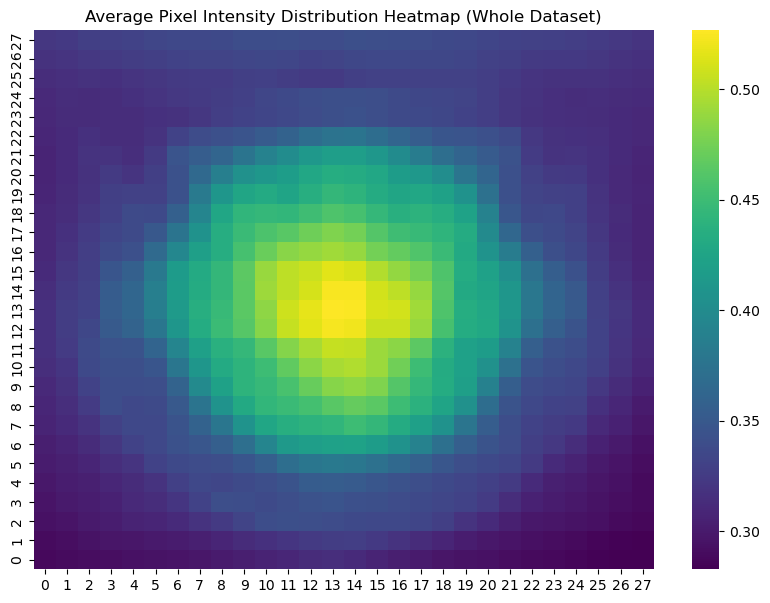

In [4]:
# Initialize variables to accumulate pixel values
pixel_sum = np.zeros((img_height, img_width), dtype=float)
num_images = 0

# Iterate through all batches of the dataset
for batch in data:
    images, labels = batch
    images = images / 255.0  # Normalize pixel values
    
    # Iterate through images in the batch
    for img in images:
        pixel_sum += img.numpy().squeeze()  # Accumulate pixel values
        num_images += 1

# Calculate the average pixel intensity
pixel_mean = pixel_sum / num_images

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(pixel_mean, cmap='viridis')  # You can choose any colormap you prefer
plt.gca().invert_yaxis()  # Reverse the y-axis direction
plt.title('Average Pixel Intensity Distribution Heatmap (Whole Dataset)')
plt.show()


In [5]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [6]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

***compile()***:
  - ***optimizer***: Stochastic Gradient Descent, **Adoptive Moment Estimator(Adam)**
  - ***loss***: **Categorical (Focal) Cross Entropy**
  - ***metrics***: **(Categorical) Accuracy**, Top K Categorical, Categorical Cross Entropy, F1/Precision/Recall, AUC, IoU, MeanIoU

Initial design for baseline model.
Our goal was to design a simple Multilayer Perceptron baseline that utilizes keras libraries and utilities. Partially because of keras's versatility as a highly customisable tool, this model poses as a milestone for us to implement different modifications and tunings in development in the next steps.

In [7]:
external_dir = "../ML_Asm2_ProjFiles/Test"  # Path to your dataset
raw_data = []

# Loop through all image files in the specified directory
for img_file in os.listdir(external_dir):
    if img_file.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        # Get the full path to the image
        img_path = os.path.join(external_dir, img_file)
        
        # Preprocess the image using the defined function
        preprocessed_img = preprocess28(img_path)
        
        # Add the preprocessed image to the raw_data list
        raw_data.append(preprocessed_img)

# Shuffle the images to randomize the order
random.shuffle(raw_data)

# Convert the list to a NumPy array
raw_data = np.array(raw_data)

In [8]:
model_1 = Sequential([ #Enhanced CNN with more diverse architecture and regularizatio
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model_2 = Sequential([ #Enhanced CNN with more diverse architecture and regularization
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)), 
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model_3 = Sequential([ #CNN with Batch Normalization and varied architecture
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model_4 = Sequential([ #Deep Neural Network (notable design dif: (2 Conv layer -> Pooling)*3
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model_5 = Sequential([ #Deep Neural Network (notable design dif: (2 Conv layer -> Pooling)*3
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(216, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='softmax')
])

model_6 = Sequential([ #CNN inspired from InceptionNet with varied architecture
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(16, activation='softmax')
])

model_7 = Sequential([ #CNN inspired from InceptionNet with BatchNorm and Maxpooling
    tf.keras.Input(shape=(28, 28, 1)),
    Rescaling(1./255),
    Conv2D(filters=16, kernel_size=(1, 1), activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(16, activation='softmax')
])


NeuralNetwork_models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,791,632 (98.39 MB)

 Trainable params: 25,791,632 (98.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - loss: 2.5601 - sparse_categorical_accuracy: 0.1758 - val_loss: 1.6968 - val_sparse_categorical_accuracy: 0.5133
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 1.7520 - sparse_categorical_accuracy: 0.4730 - val_loss: 1.2857 - val_sparse_categorical_accuracy: 0.6552
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - loss: 1.3721 - sparse_categorical_accuracy: 0.5936 - val_loss: 1.0358 - val_sparse_categorical_accuracy: 0.7222
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 1.1169 - sparse_categorical_accuracy: 0.6803 - val_loss: 0.8362 - val_sparse_categorical_accuracy: 0.7789
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - loss: 0.9131 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.7072 - val_sparse_categorical_accuracy: 0.8052
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - loss: 0.7746 - sparse_categorical_accuracy: 0.7803 - val_loss: 0.6102 - val_sparse_categorical_accuracy: 0.838

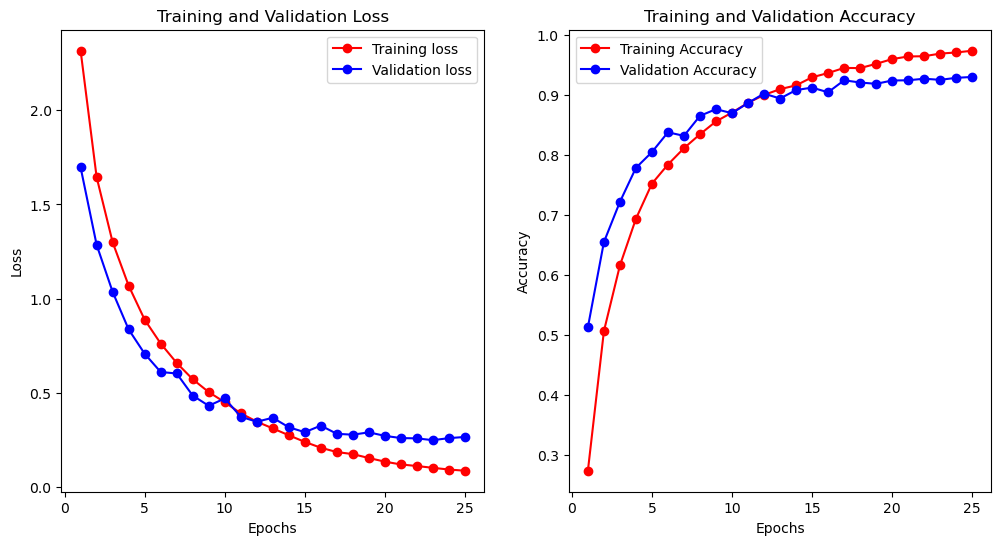

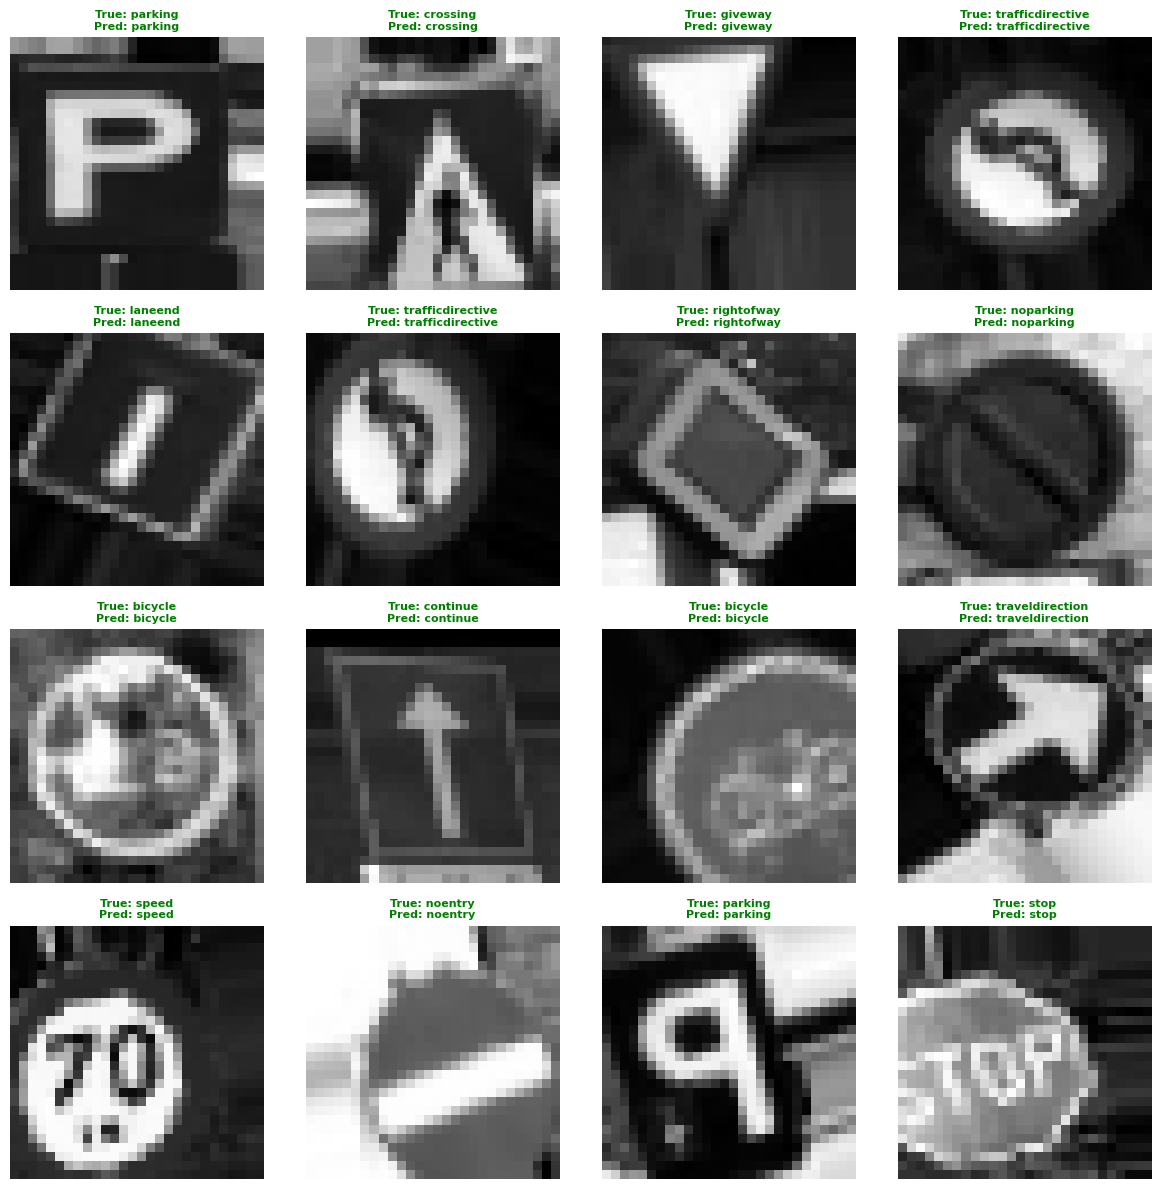

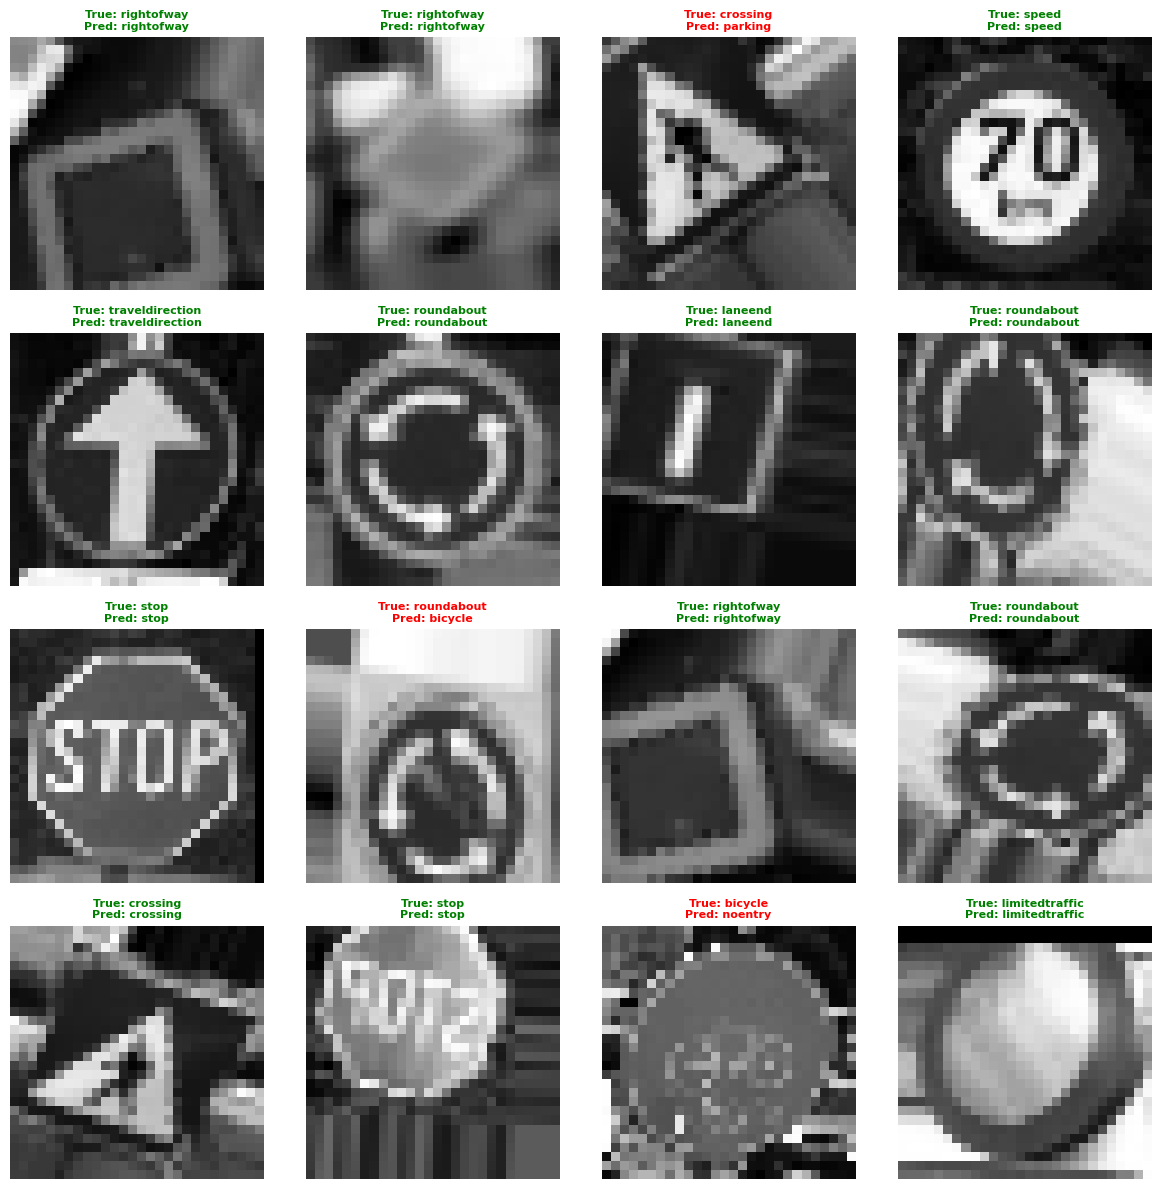

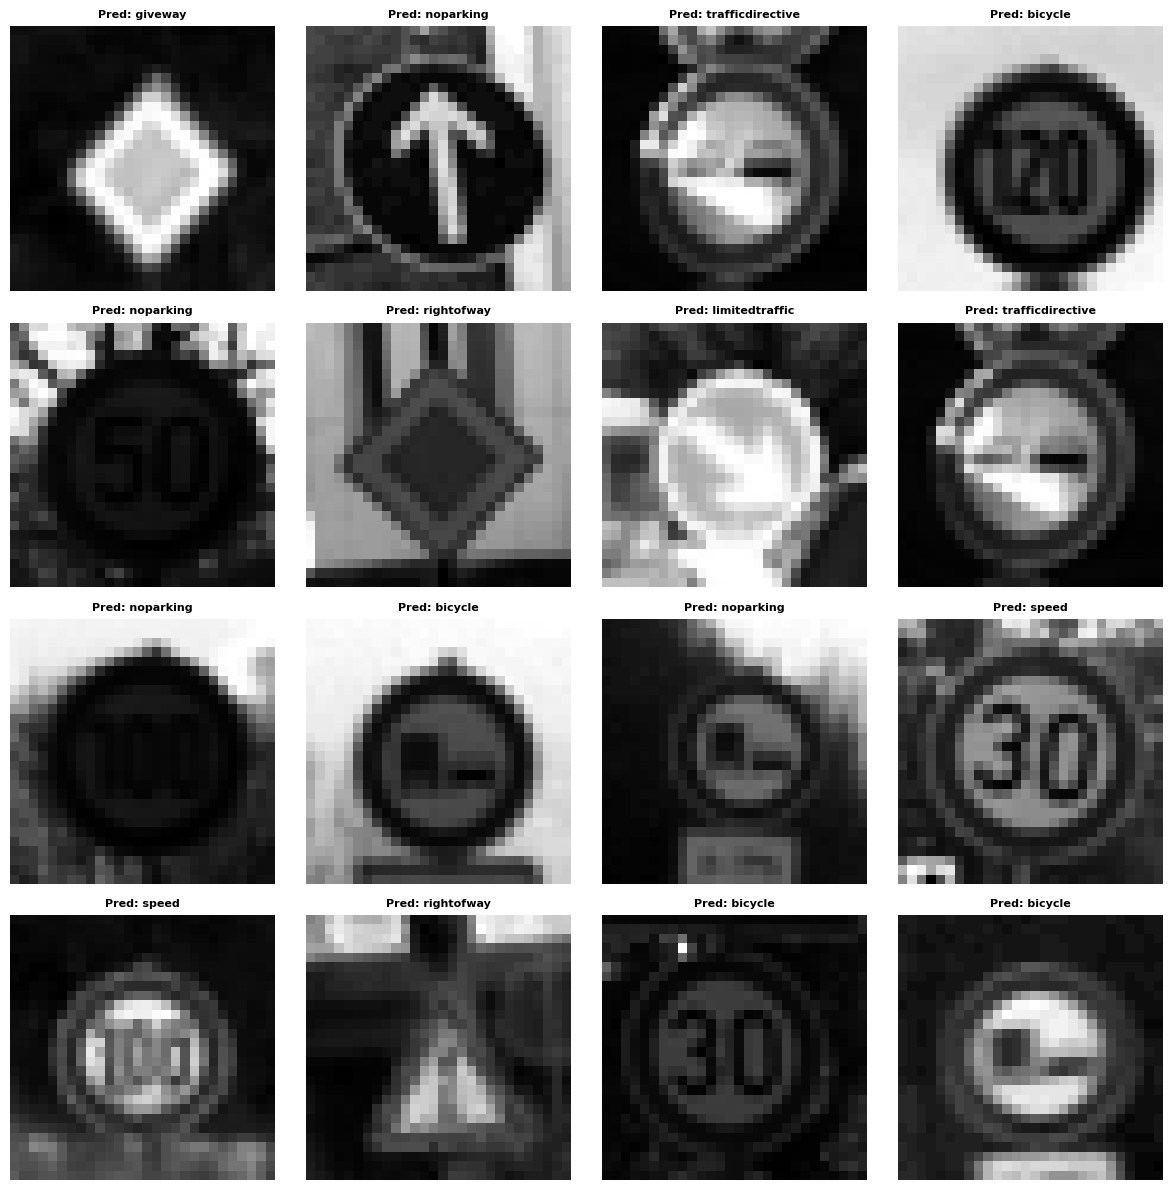

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,288 (524.56 KB)

 Trainable params: 134,288 (524.56 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 2.7690 - sparse_categorical_accuracy: 0.0665 - val_loss: 2.7449 - val_sparse_categorical_accuracy: 0.1348
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.7333 - sparse_categorical_accuracy: 0.1112 - val_loss: 2.6676 - val_sparse_categorical_accuracy: 0.1600
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6333 - sparse_categorical_accuracy: 0.1651 - val_loss: 2.4771 - val_sparse_categorical_accuracy: 0.2959
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.4492 - sparse_categorical_accuracy: 0.2370 - val_loss: 2.2469 - val_sparse_categorical_accuracy: 0.3730
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.2612 - sparse_categorical_accuracy: 0.2879 - val_loss: 2.0478 - val_sparse_categorical_accuracy: 0.4267
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.0954 - sparse_categorical_accuracy: 0.3459 - val_loss: 1.8865 - val_sparse_categorical_accuracy: 0.4537
Epoch 7/25

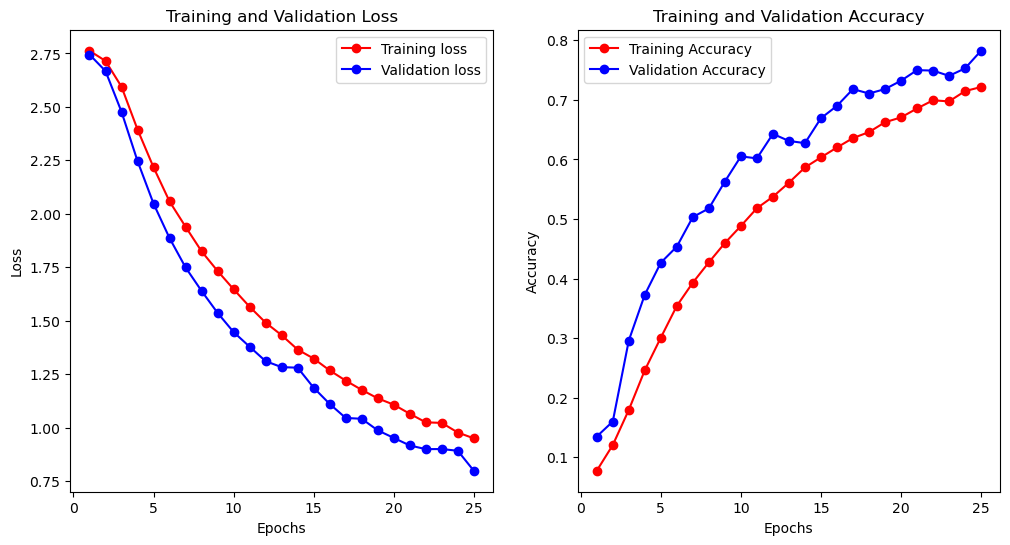

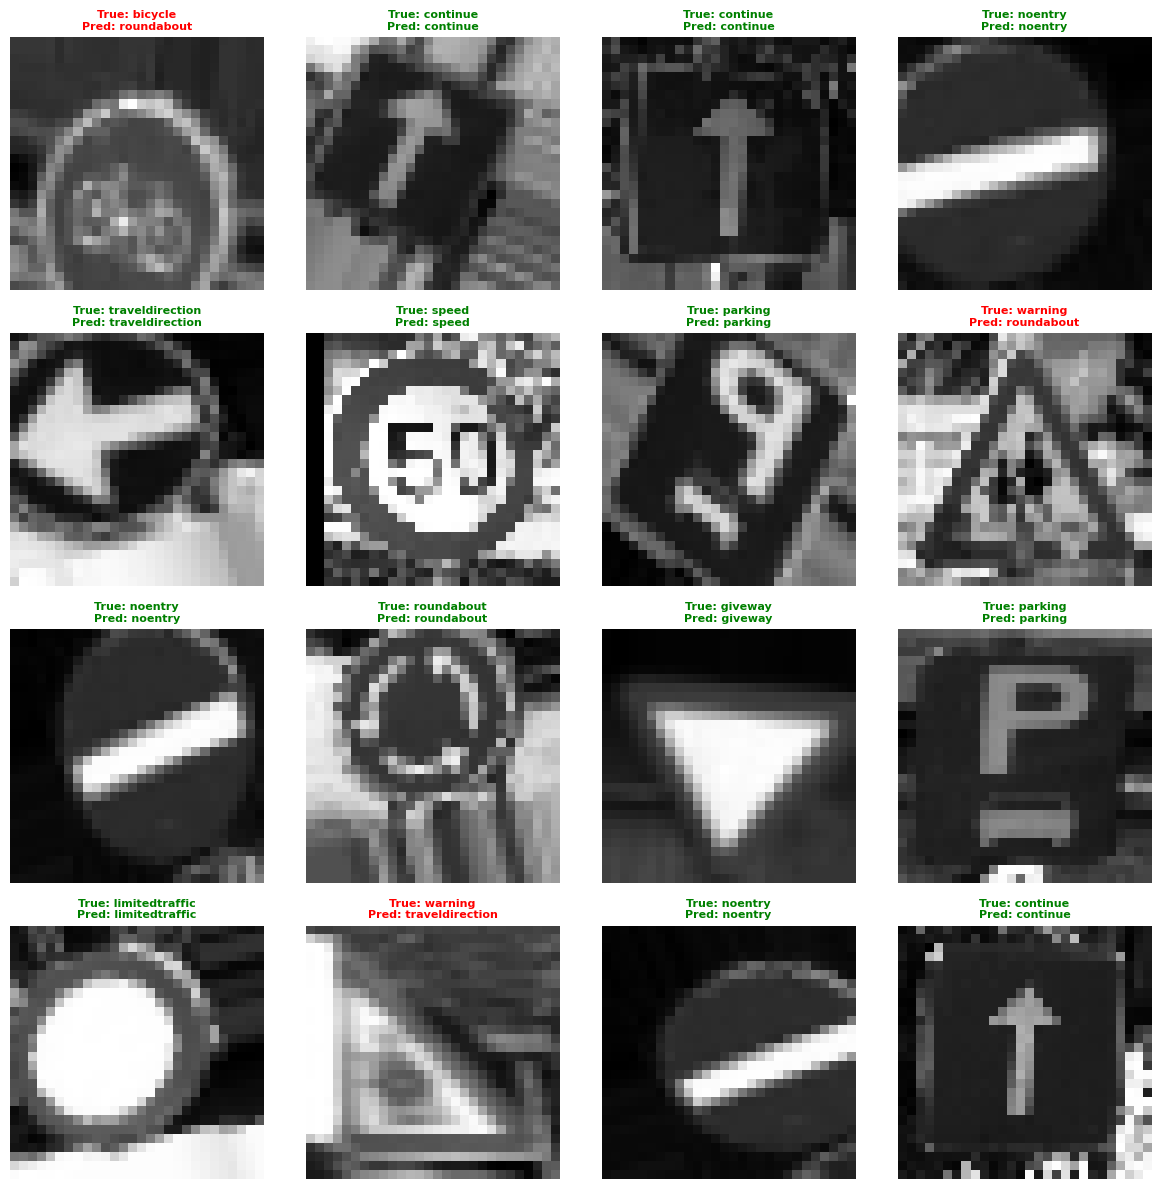

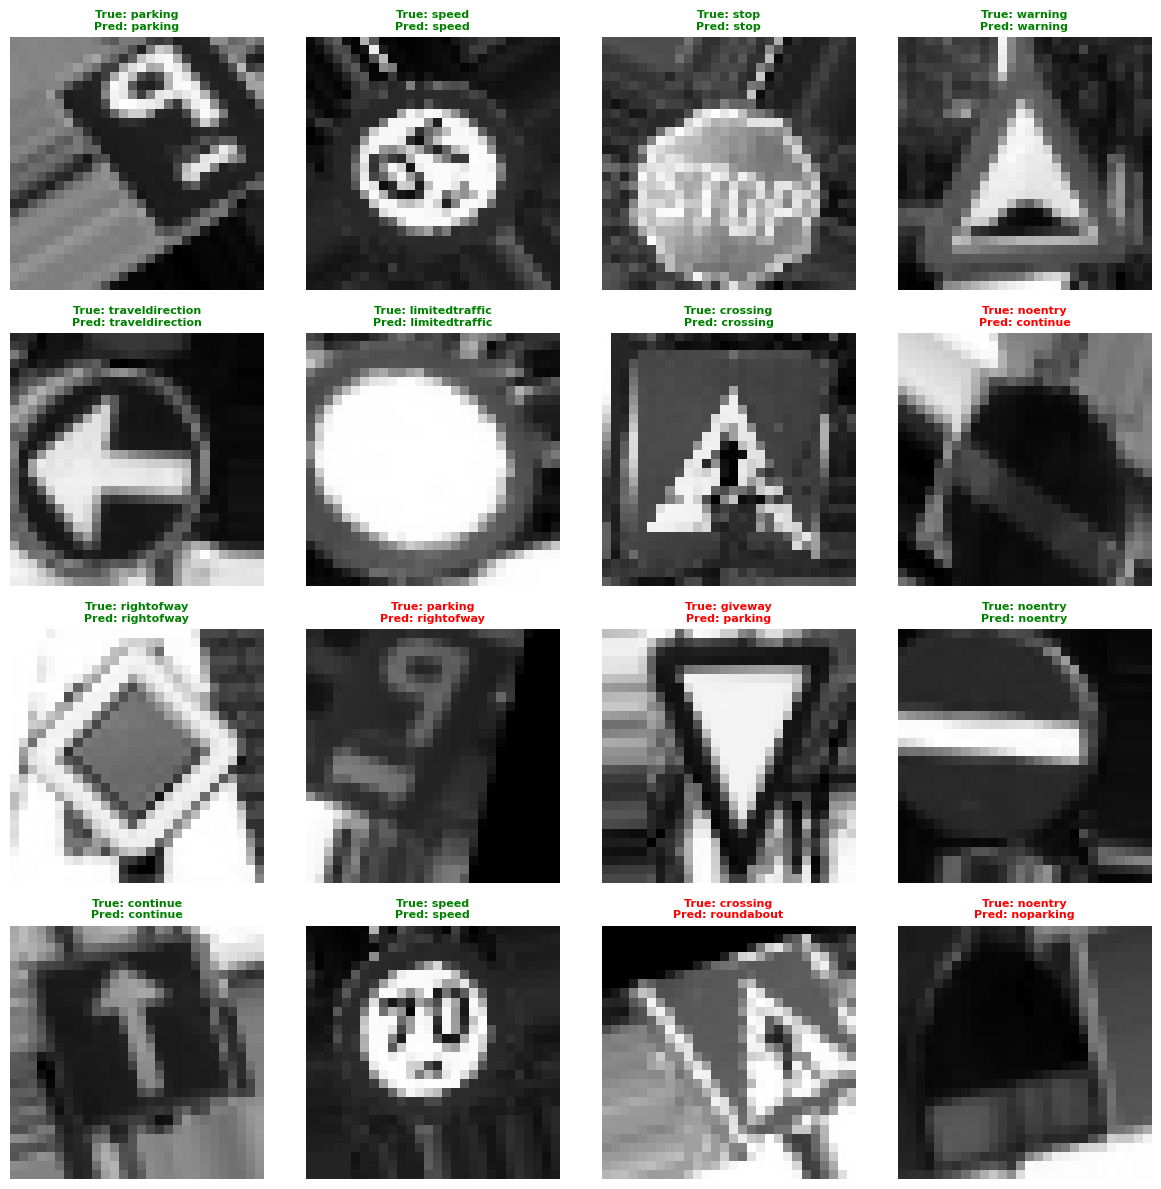

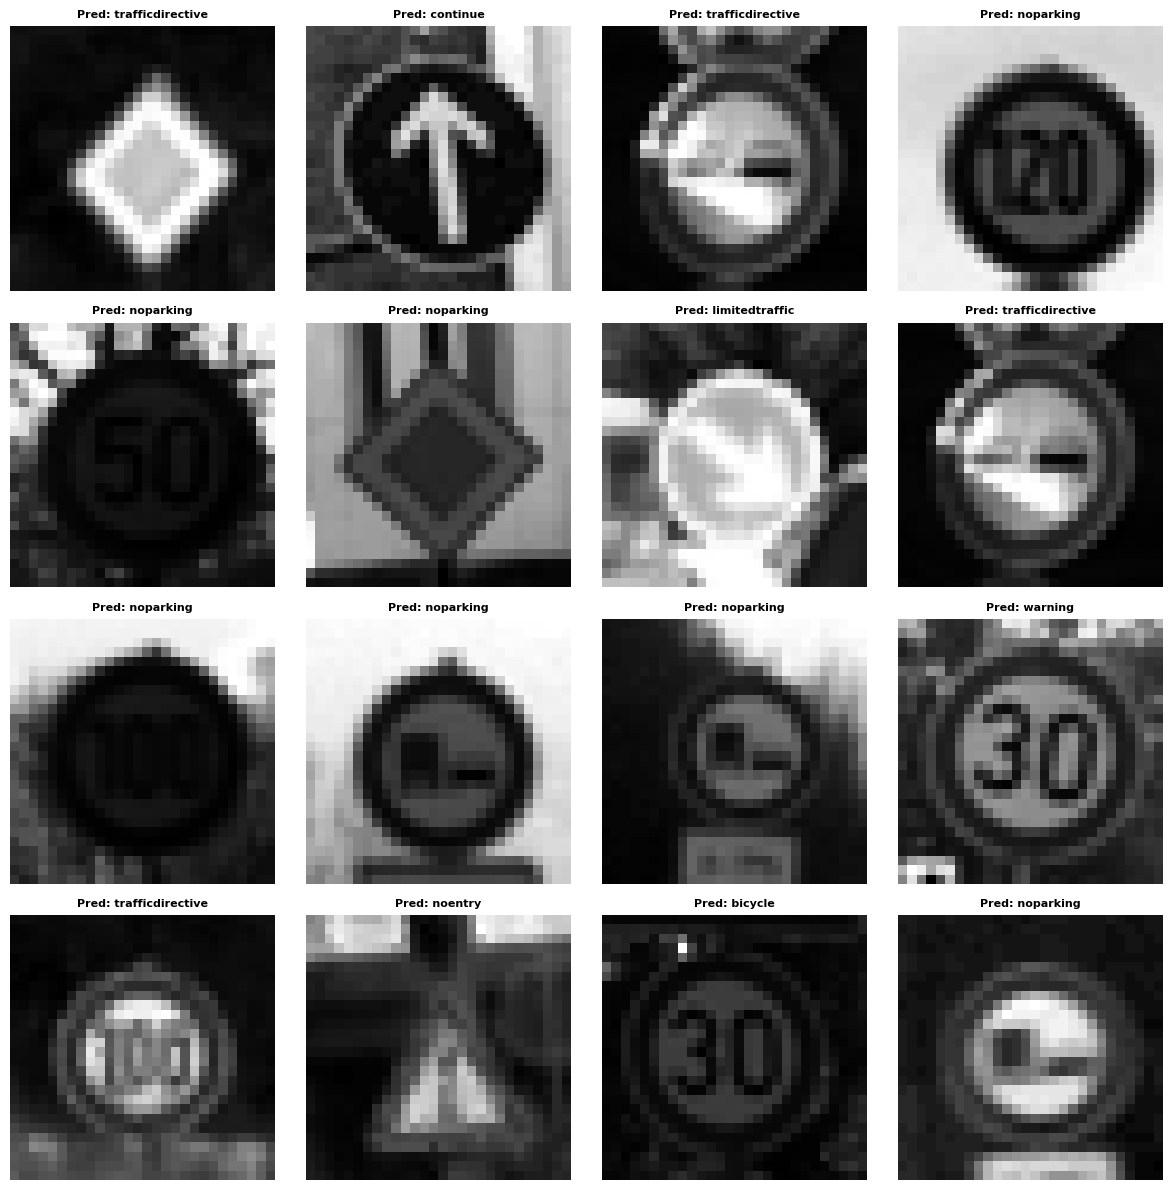

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,568 (685.81 KB)

 Trainable params: 175,344 (684.94 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.4704 - sparse_categorical_accuracy: 0.1322 - val_loss: 2.8372 - val_sparse_categorical_accuracy: 0.1063
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.9804 - sparse_categorical_accuracy: 0.3797 - val_loss: 3.0656 - val_sparse_categorical_accuracy: 0.0704
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 1.5184 - sparse_categorical_accuracy: 0.5388 - val_loss: 3.2293 - val_sparse_categorical_accuracy: 0.0789
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.6319 - val_loss: 2.4266 - val_sparse_categorical_accuracy: 0.1970
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.0444 - sparse_categorical_accuracy: 0.6920 - val_loss: 1.3928 - val_sparse_categorical_accuracy: 0.5626
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.9022 - sparse_categorical_accuracy: 0.7355 - val_loss: 0.8738 - val_sparse_categorical_accuracy: 0.7600
Epoch 7/25

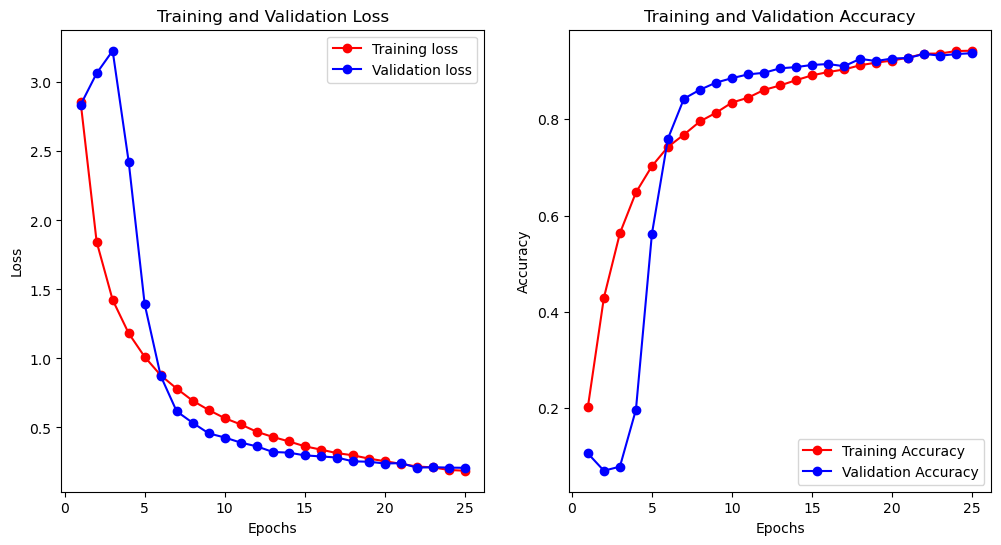

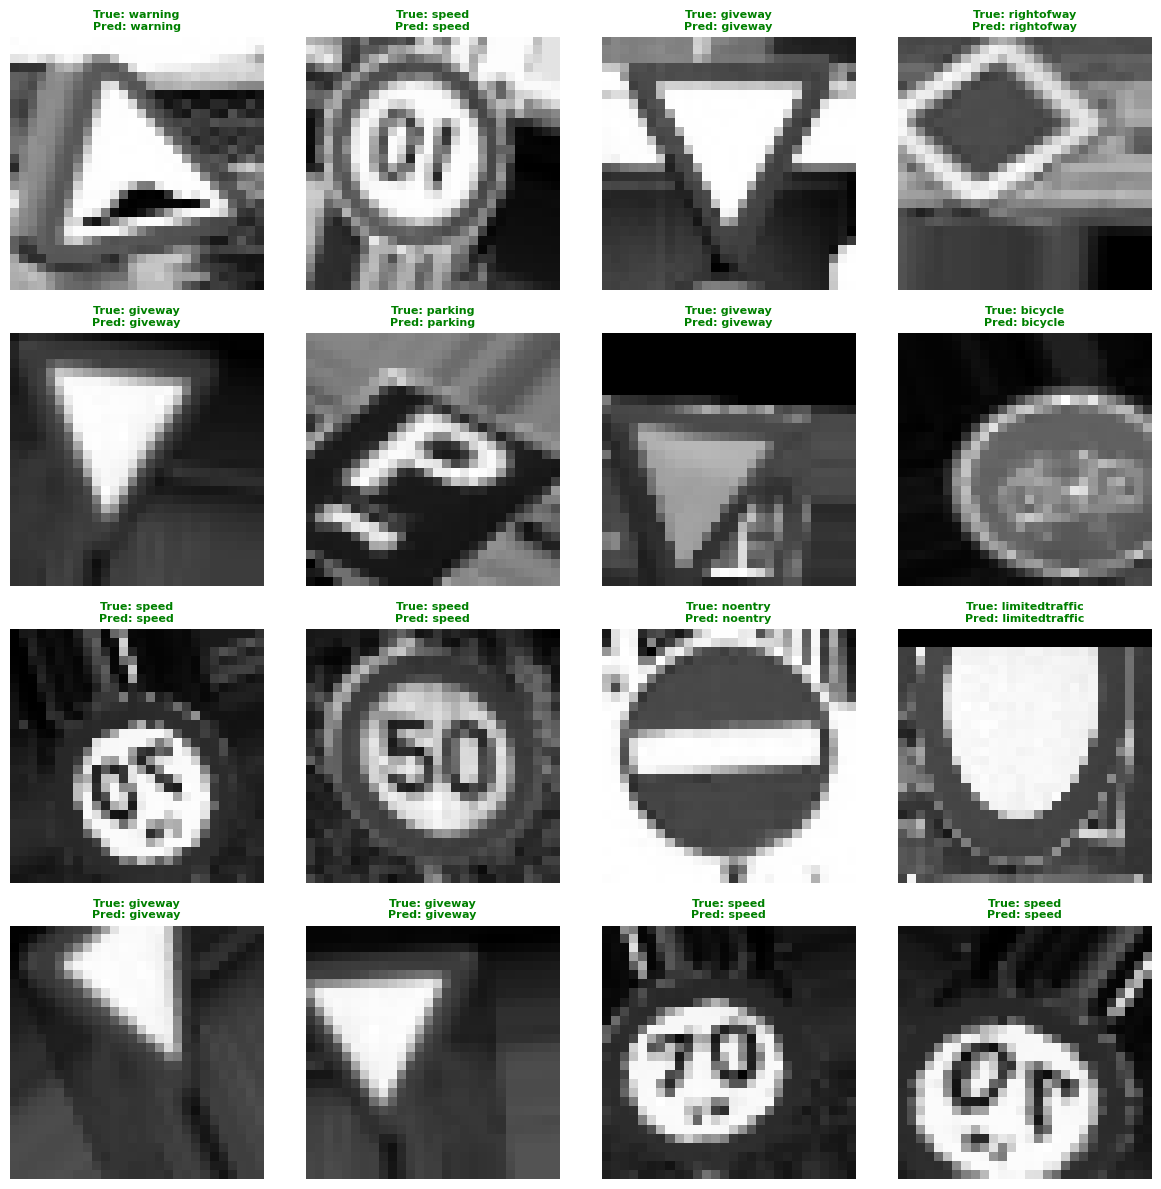

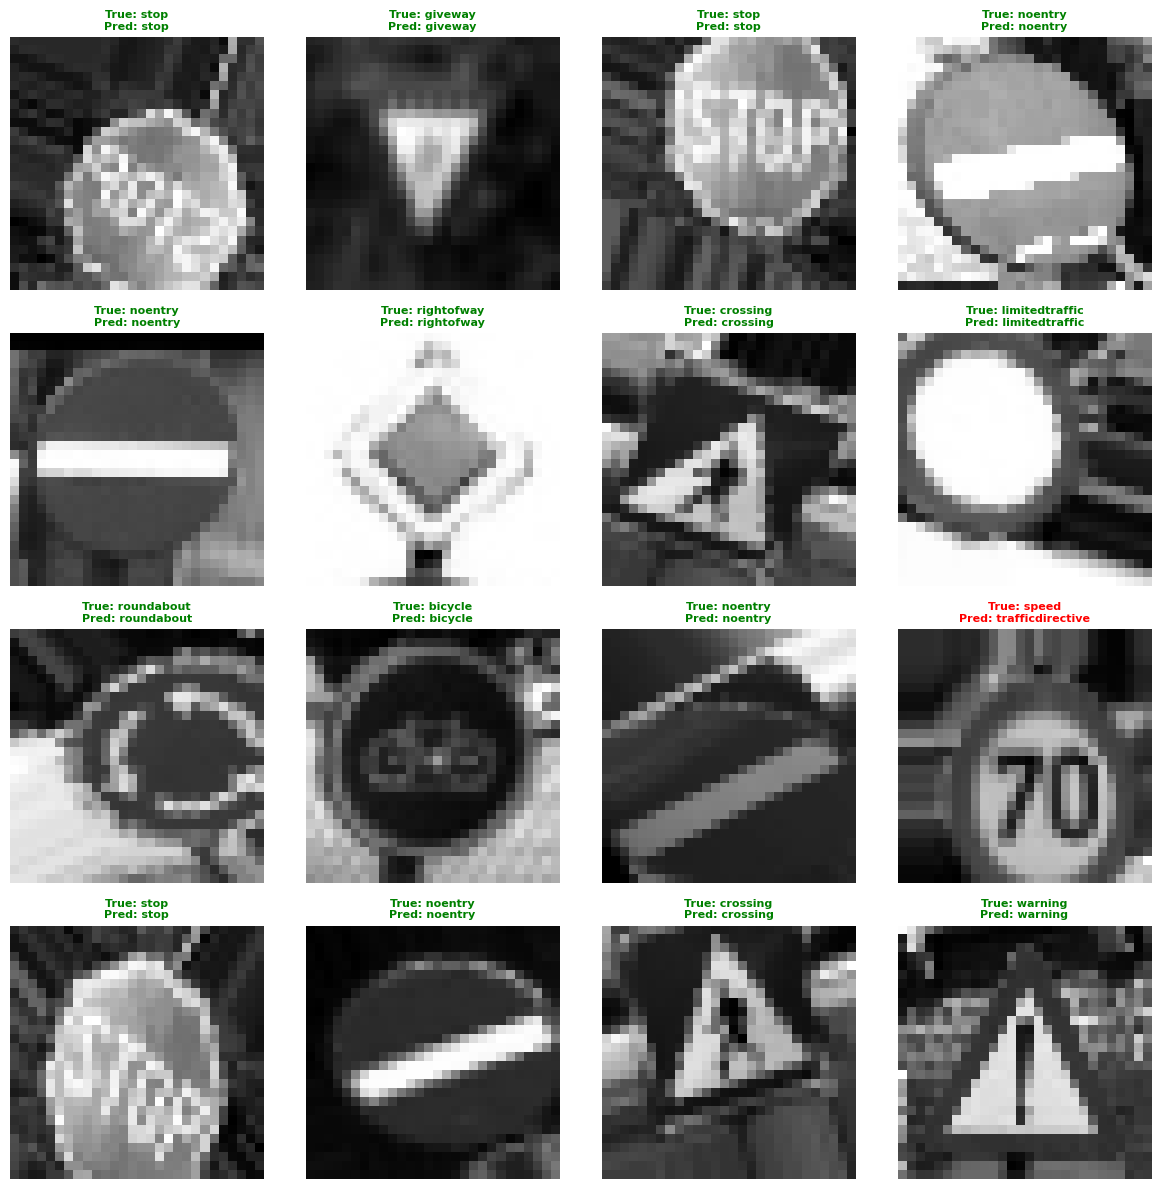

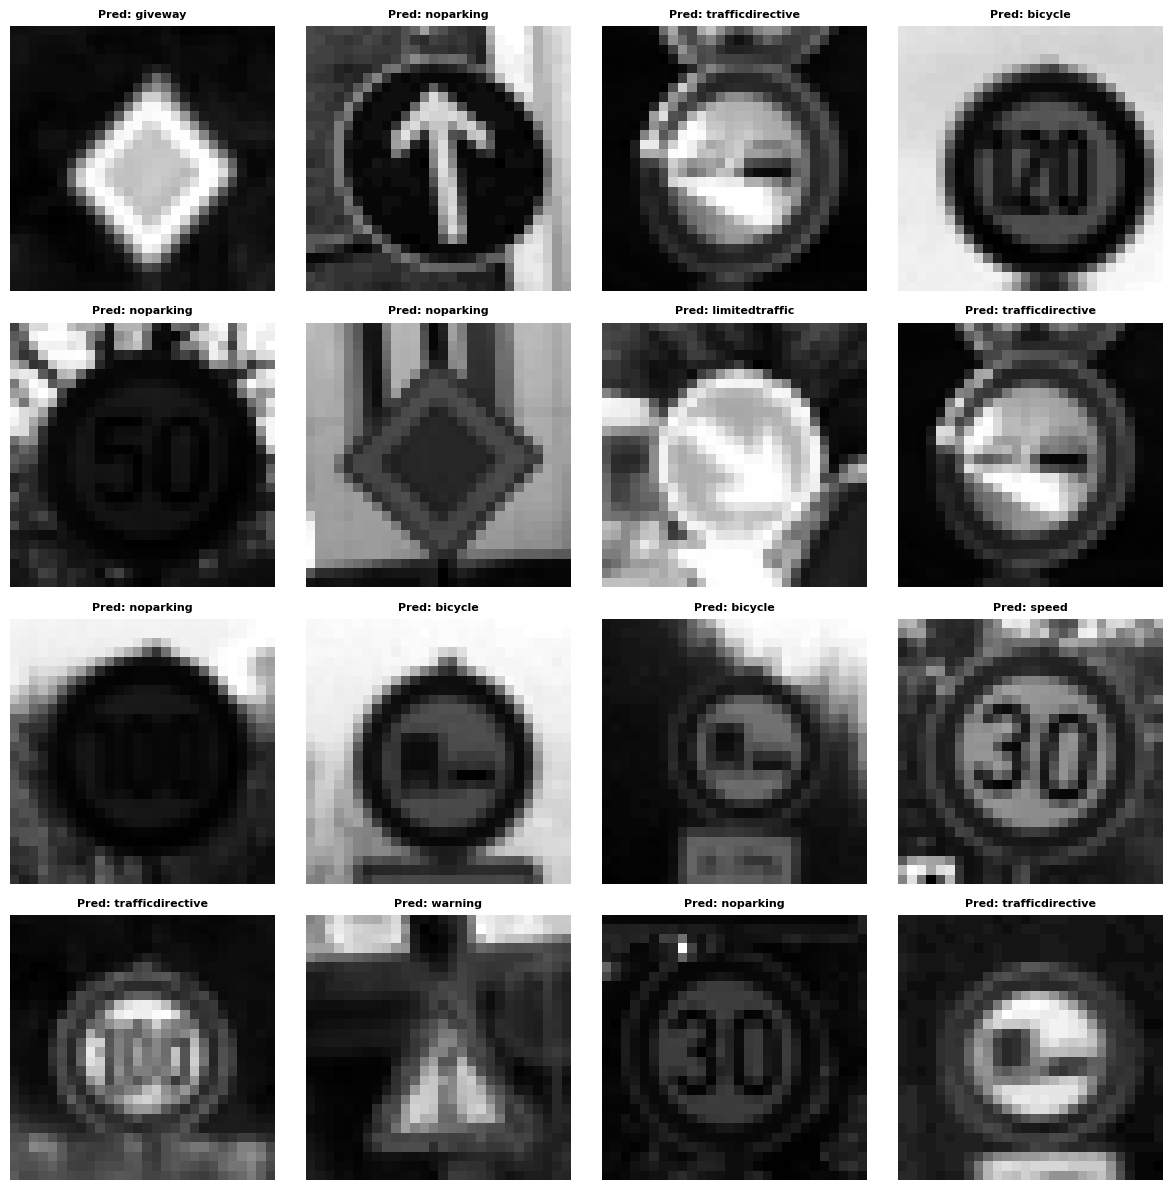

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 216)                 │         249,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          27,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,320 (2.16 MB)

 Trainable params: 565,320 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 2.7540 - sparse_categorical_accuracy: 0.0931 - val_loss: 2.5744 - val_sparse_categorical_accuracy: 0.1715
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 2.5201 - sparse_categorical_accuracy: 0.1947 - val_loss: 2.2015 - val_sparse_categorical_accuracy: 0.3463
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 2.1865 - sparse_categorical_accuracy: 0.3016 - val_loss: 1.7952 - val_sparse_categorical_accuracy: 0.4759
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 1.9494 - sparse_categorical_accuracy: 0.3892 - val_loss: 1.5745 - val_sparse_categorical_accuracy: 0.5400
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 1.7607 - sparse_categorical_accuracy: 0.4554 - val_loss: 1.3168 - val_sparse_categorical_accuracy: 0.6463
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 1.6061 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.1964 - val_sparse_categorical_accuracy: 0.6452
Epoch 7/25

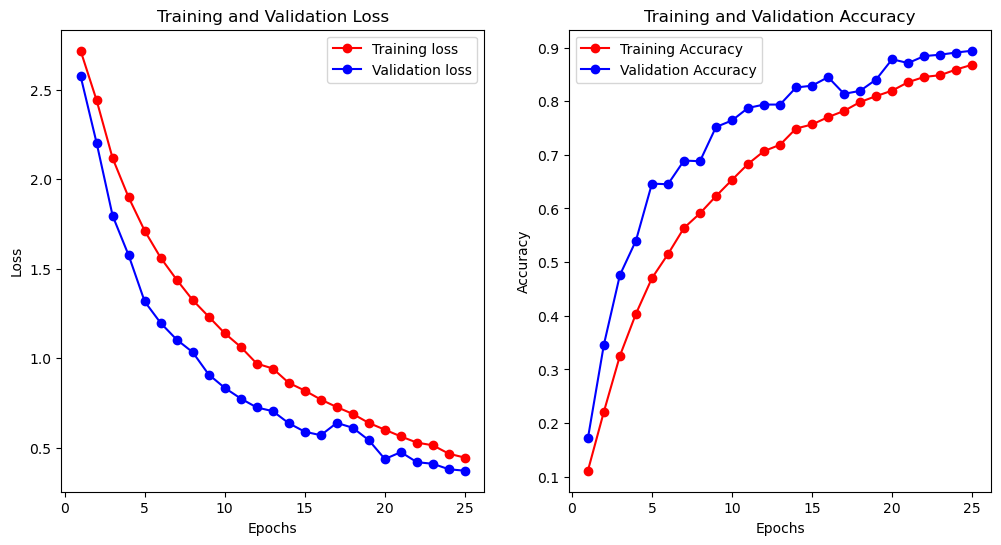

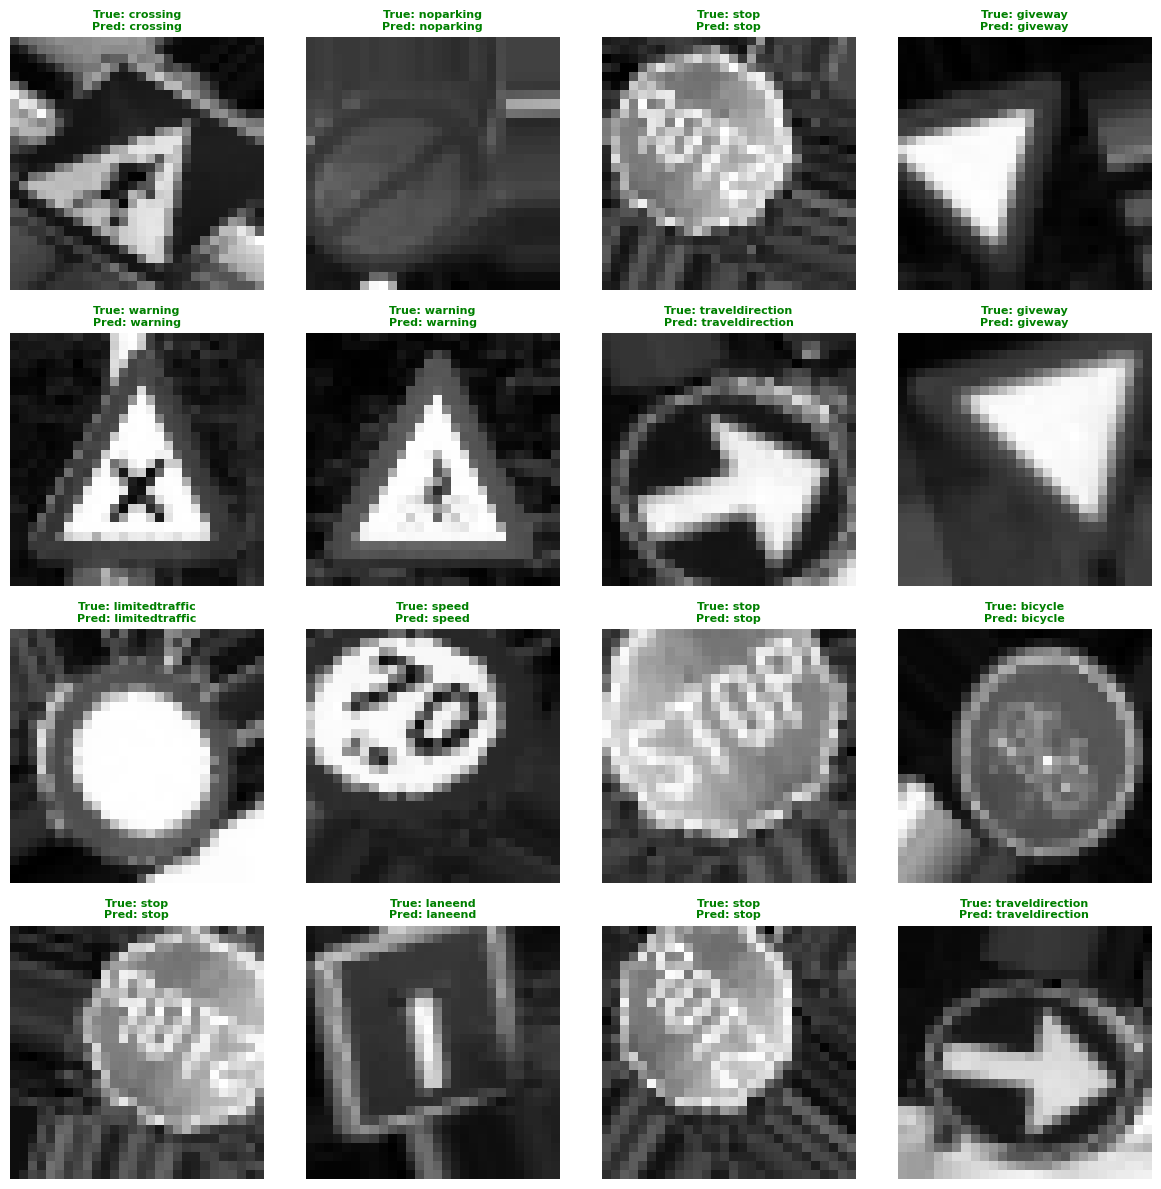

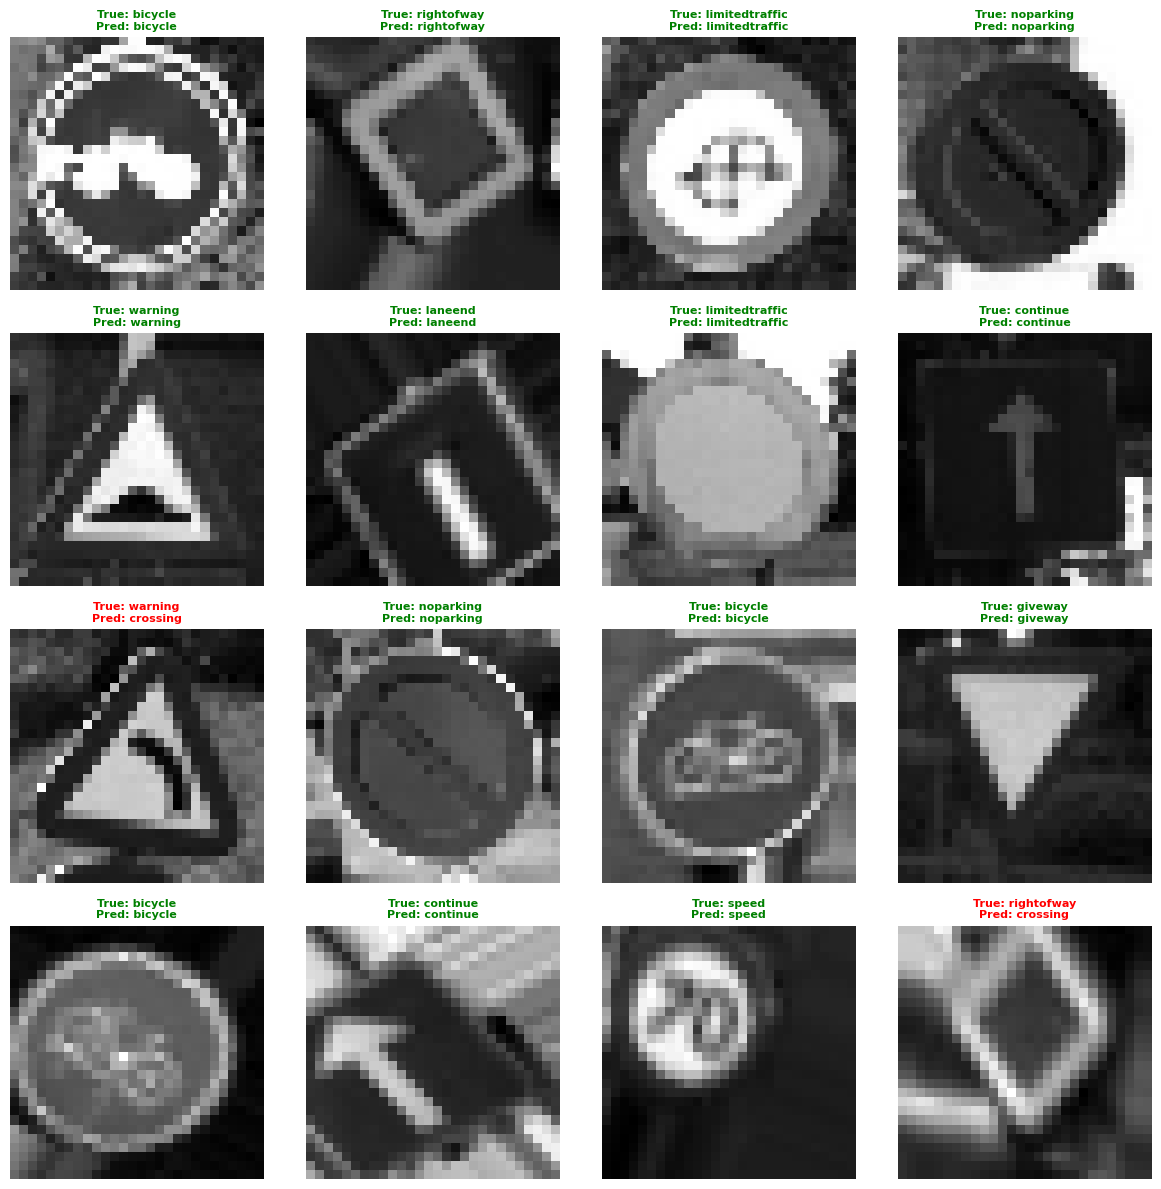

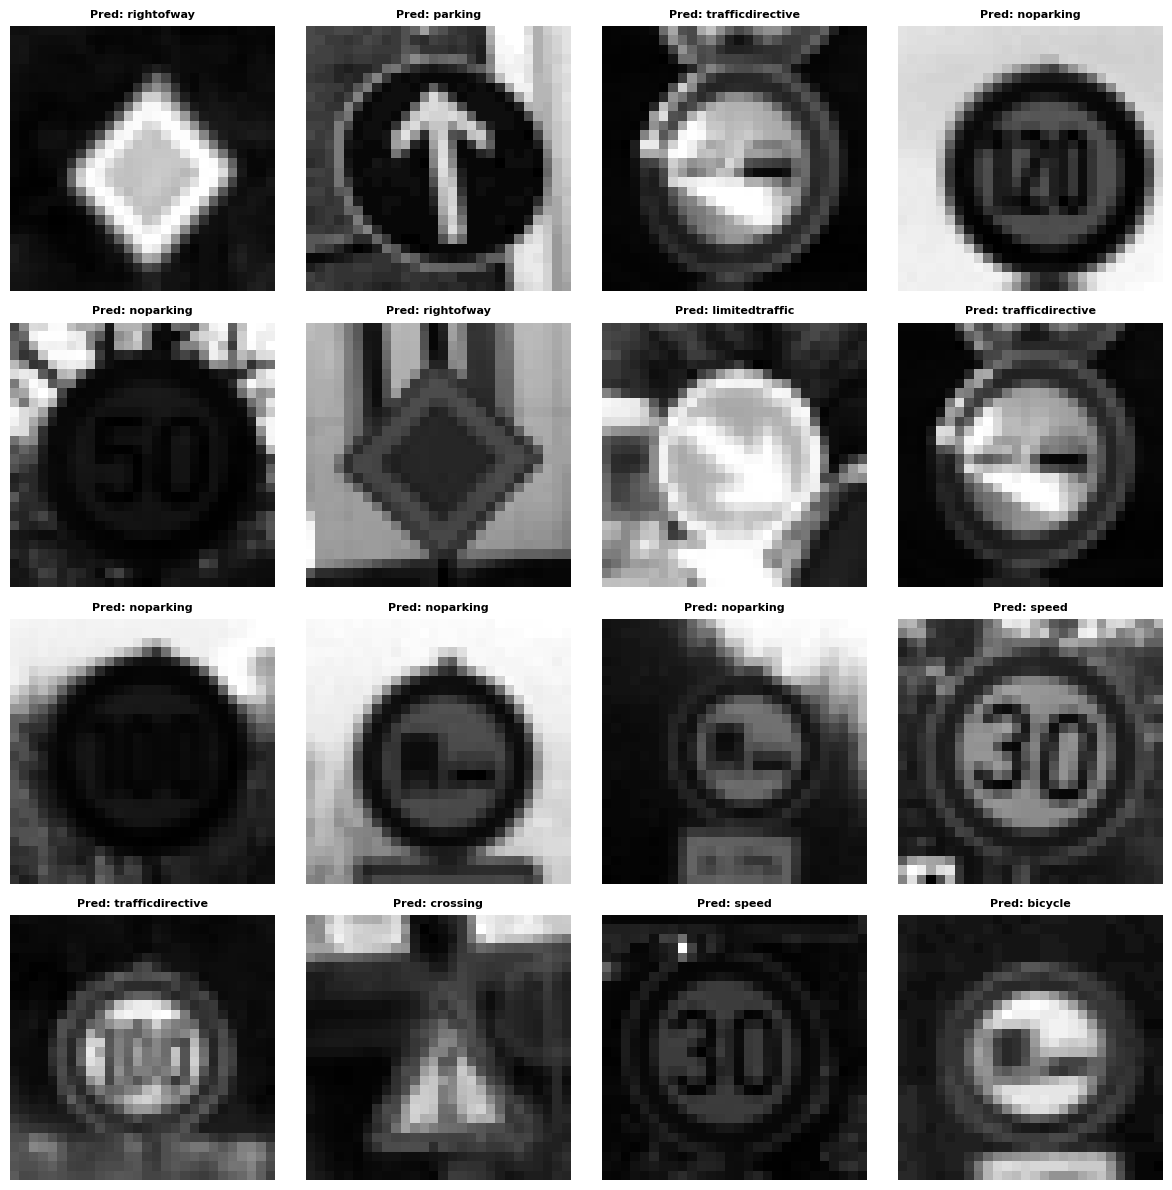

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 216)                 │         249,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          27,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 566,216 (2.16 MB)

 Trainable params: 565,768 (2.16 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 2.8520 - sparse_categorical_accuracy: 0.1895 - val_loss: 2.8142 - val_sparse_categorical_accuracy: 0.1033
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 1.4791 - sparse_categorical_accuracy: 0.5498 - val_loss: 2.8767 - val_sparse_categorical_accuracy: 0.0711
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.9760 - sparse_categorical_accuracy: 0.7185 - val_loss: 2.9377 - val_sparse_categorical_accuracy: 0.0722
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.7913 - val_loss: 2.6748 - val_sparse_categorical_accuracy: 0.1556
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.5312 - sparse_categorical_accuracy: 0.8497 - val_loss: 1.8140 - val_sparse_categorical_accuracy: 0.4911
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8821 - val_loss: 0.7702 - val_sparse_categorical_accuracy: 0.8070
Epoch 7/2

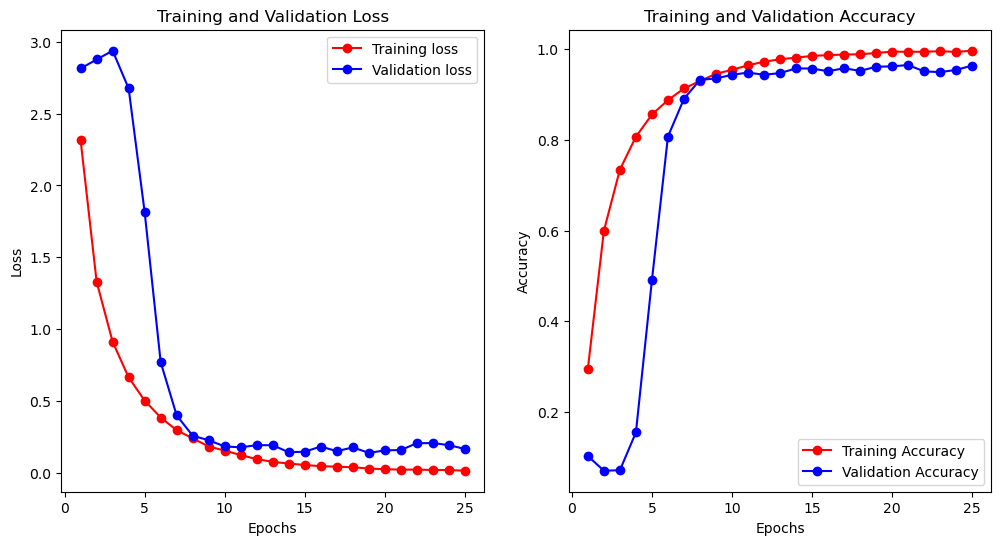

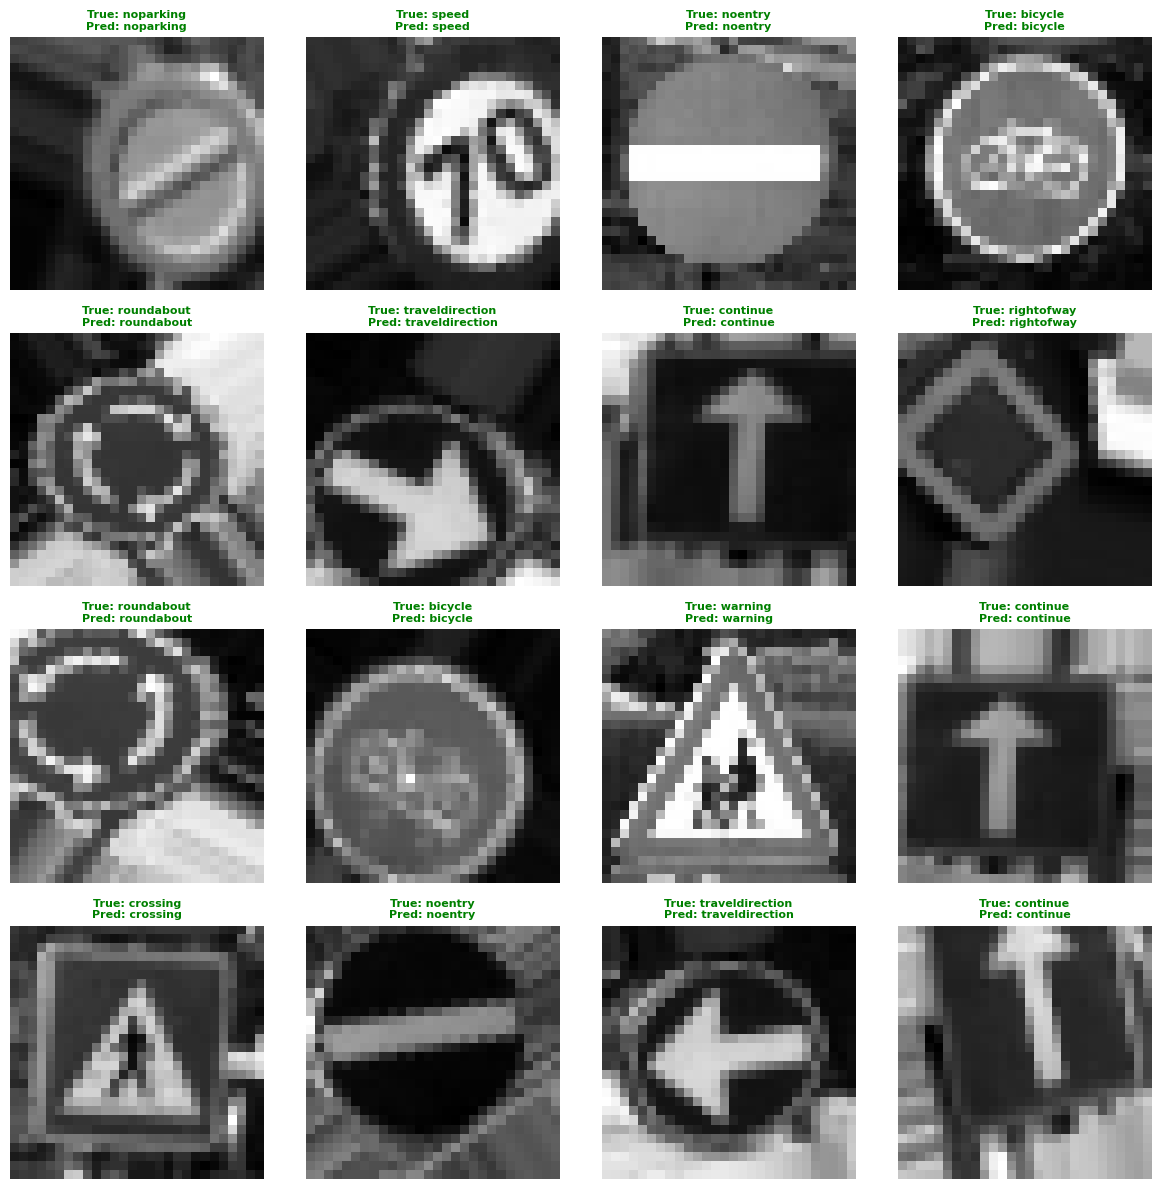

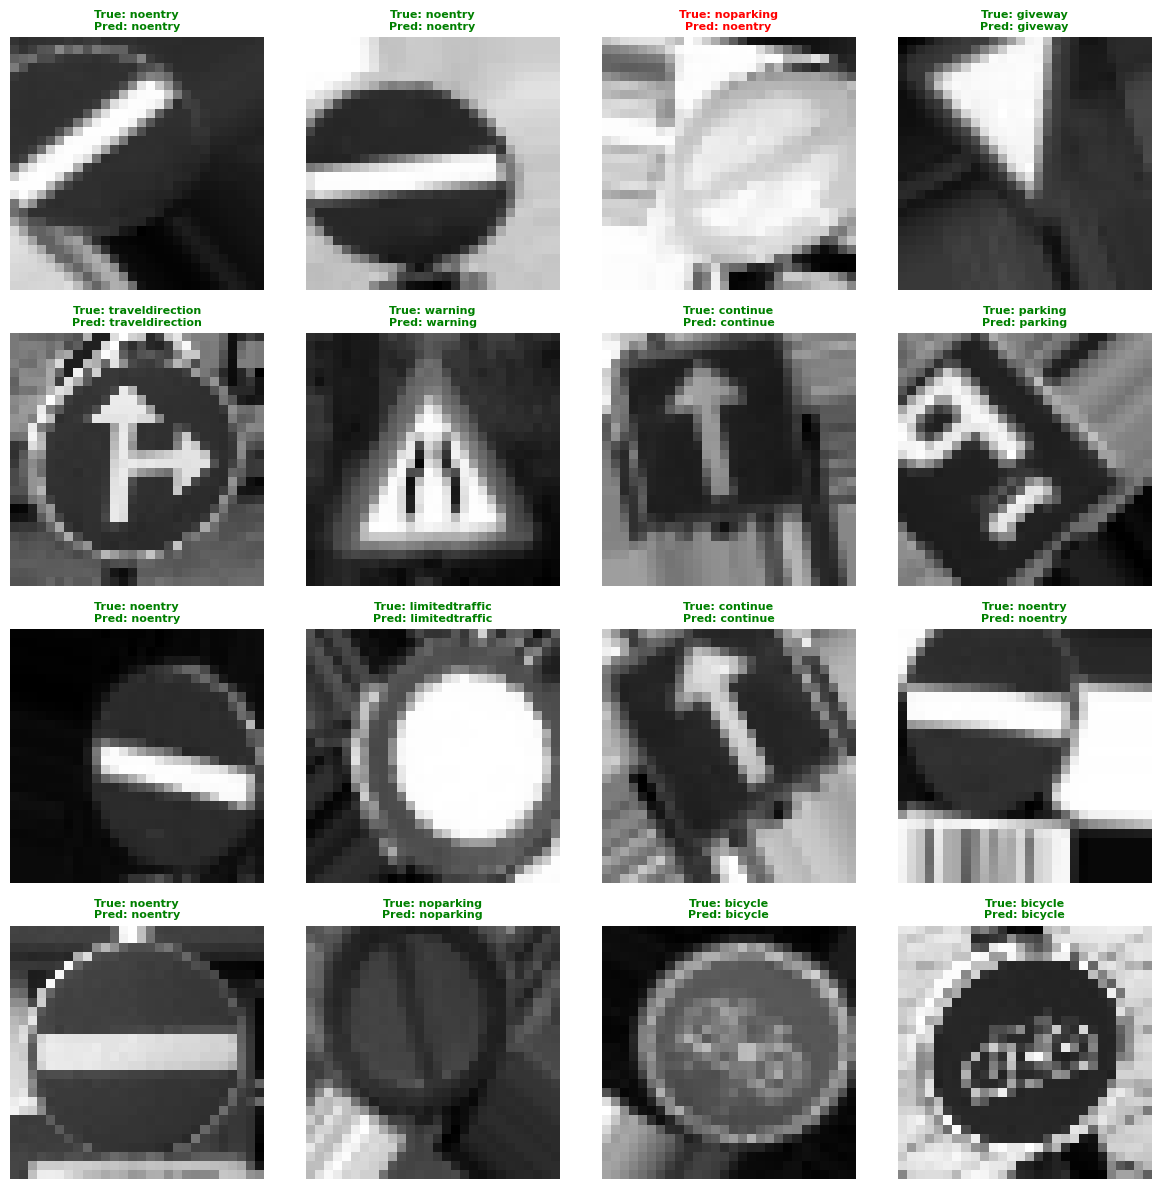

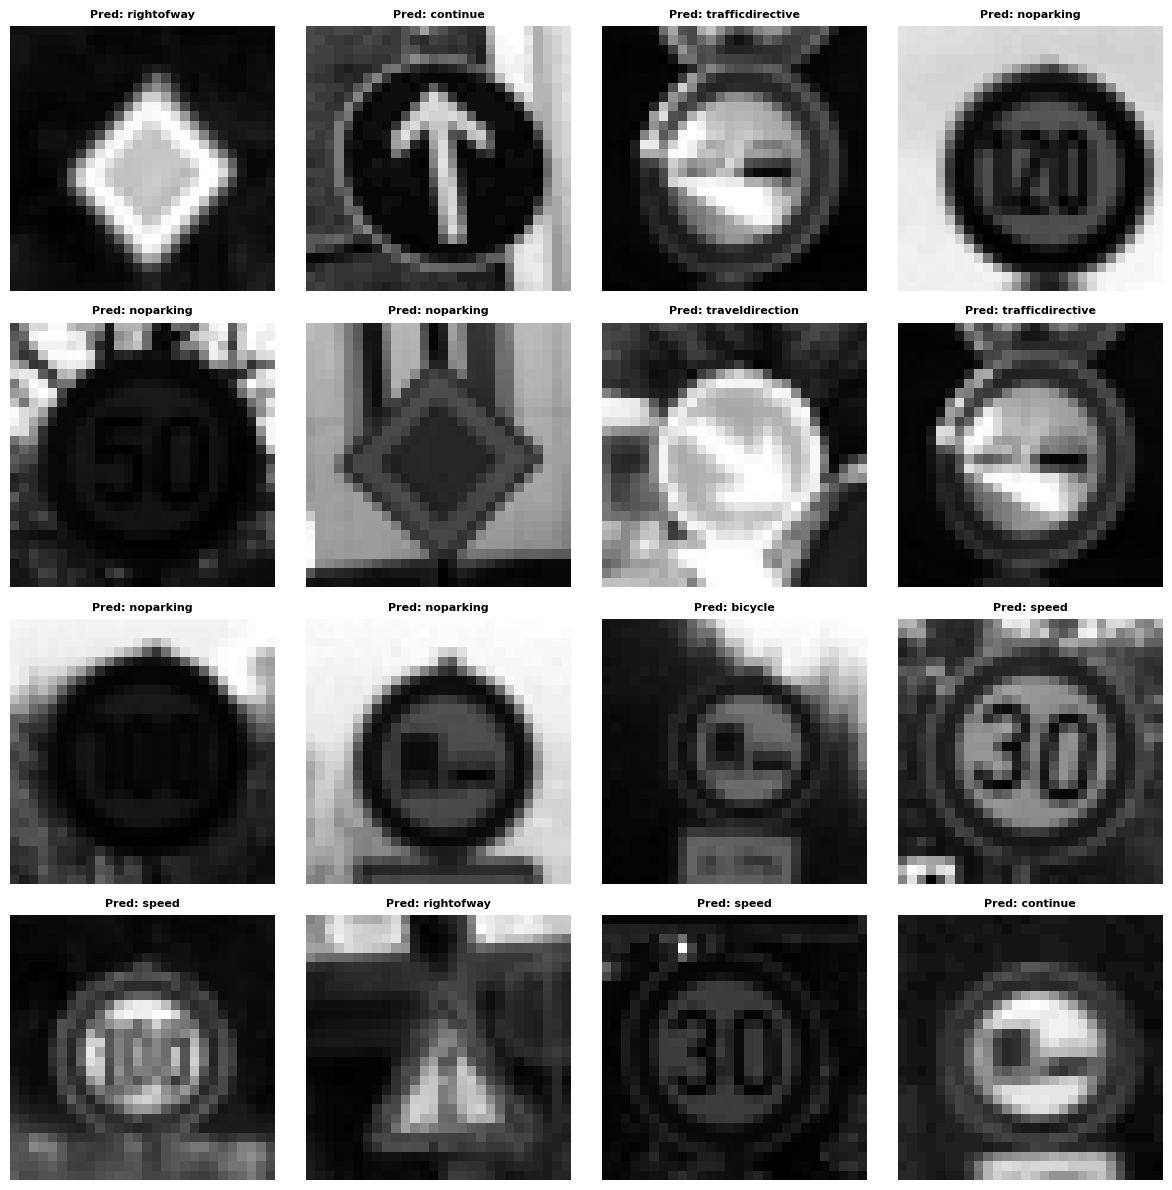

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141,840 (4.36 MB)

 Trainable params: 1,141,840 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - loss: 2.6191 - sparse_categorical_accuracy: 0.1558 - val_loss: 2.0089 - val_sparse_categorical_accuracy: 0.3556
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - loss: 1.8950 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.4380 - val_sparse_categorical_accuracy: 0.5822
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 1.4256 - sparse_categorical_accuracy: 0.5851 - val_loss: 1.0797 - val_sparse_categorical_accuracy: 0.7000
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 1.1153 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.8917 - val_sparse_categorical_accuracy: 0.7574
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 0.8894 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7748
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - loss: 0.7415 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.804

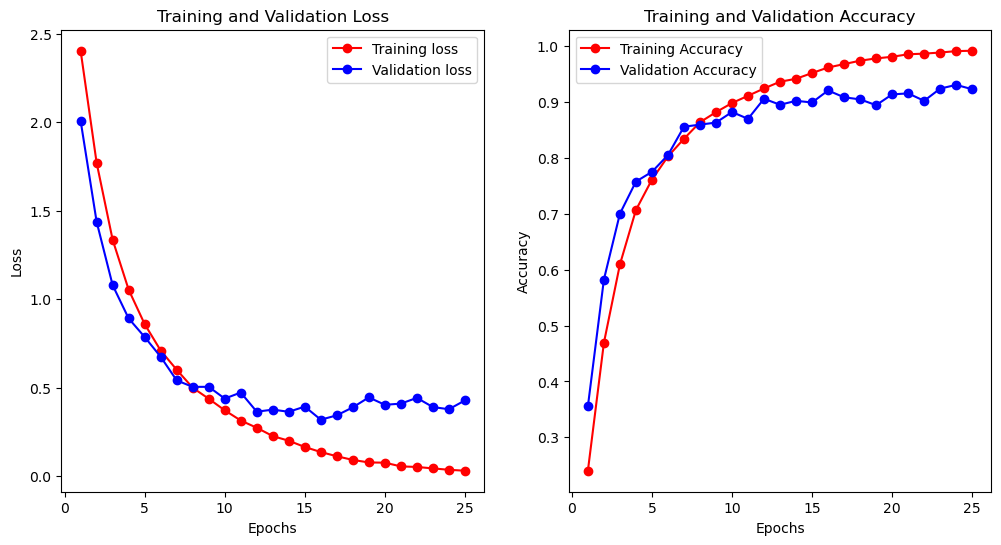

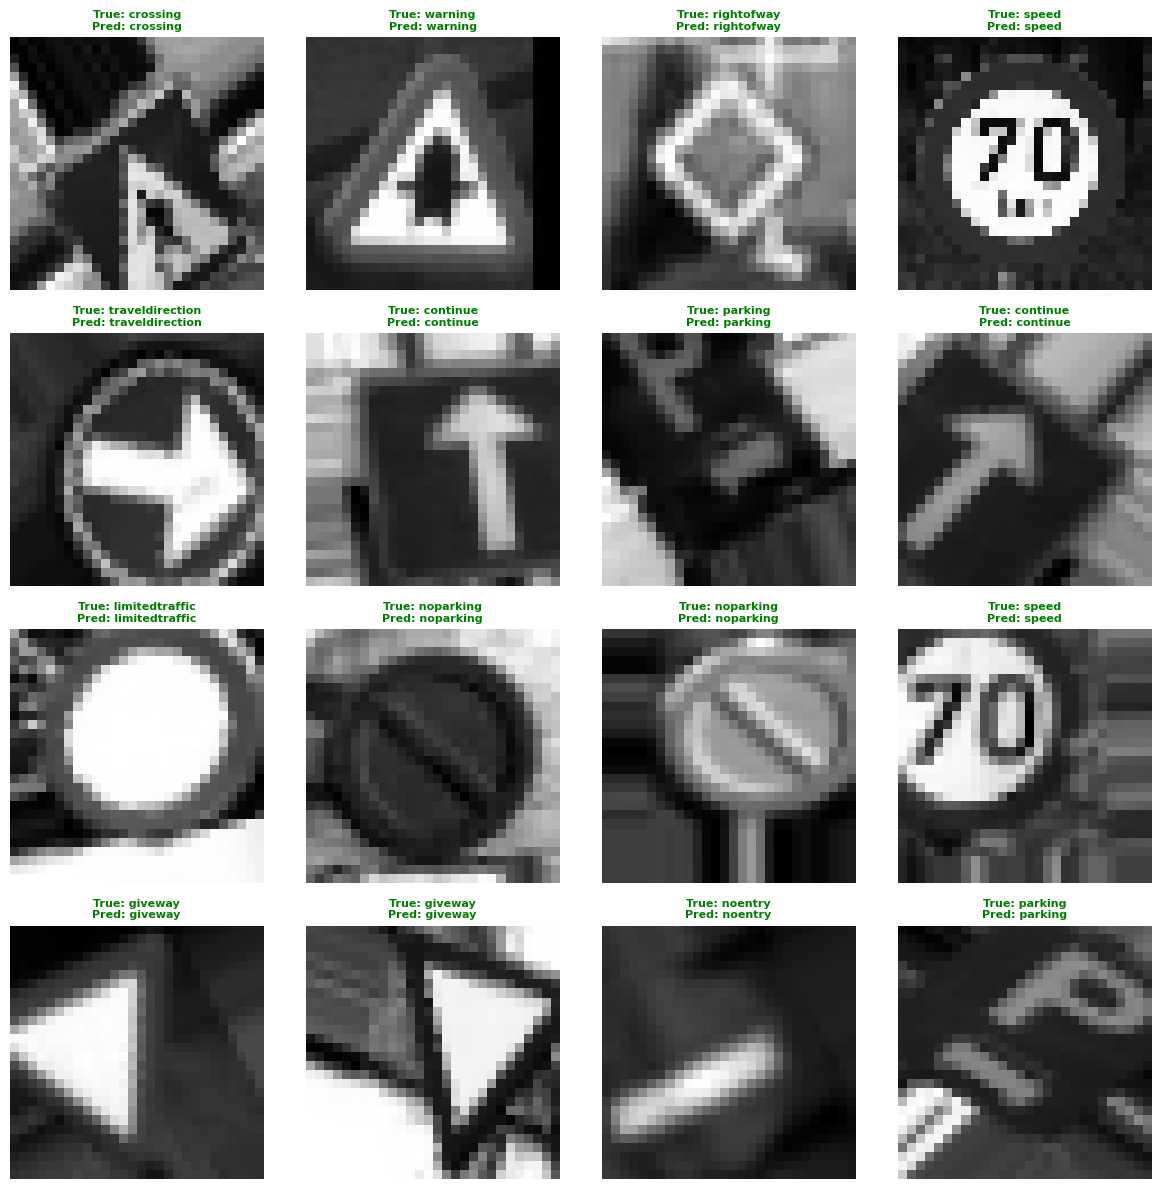

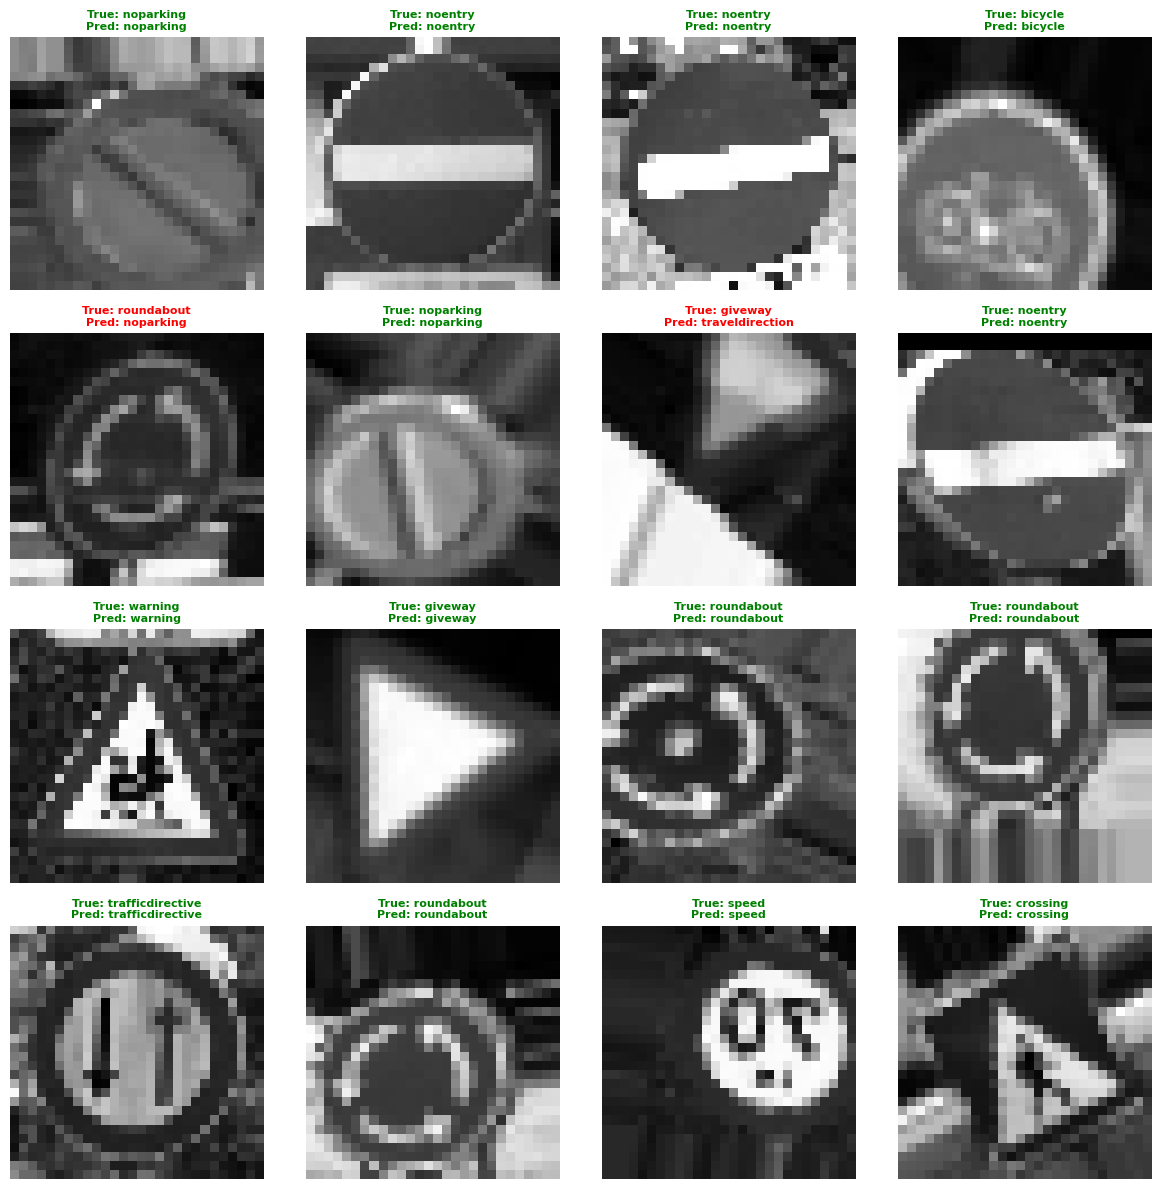

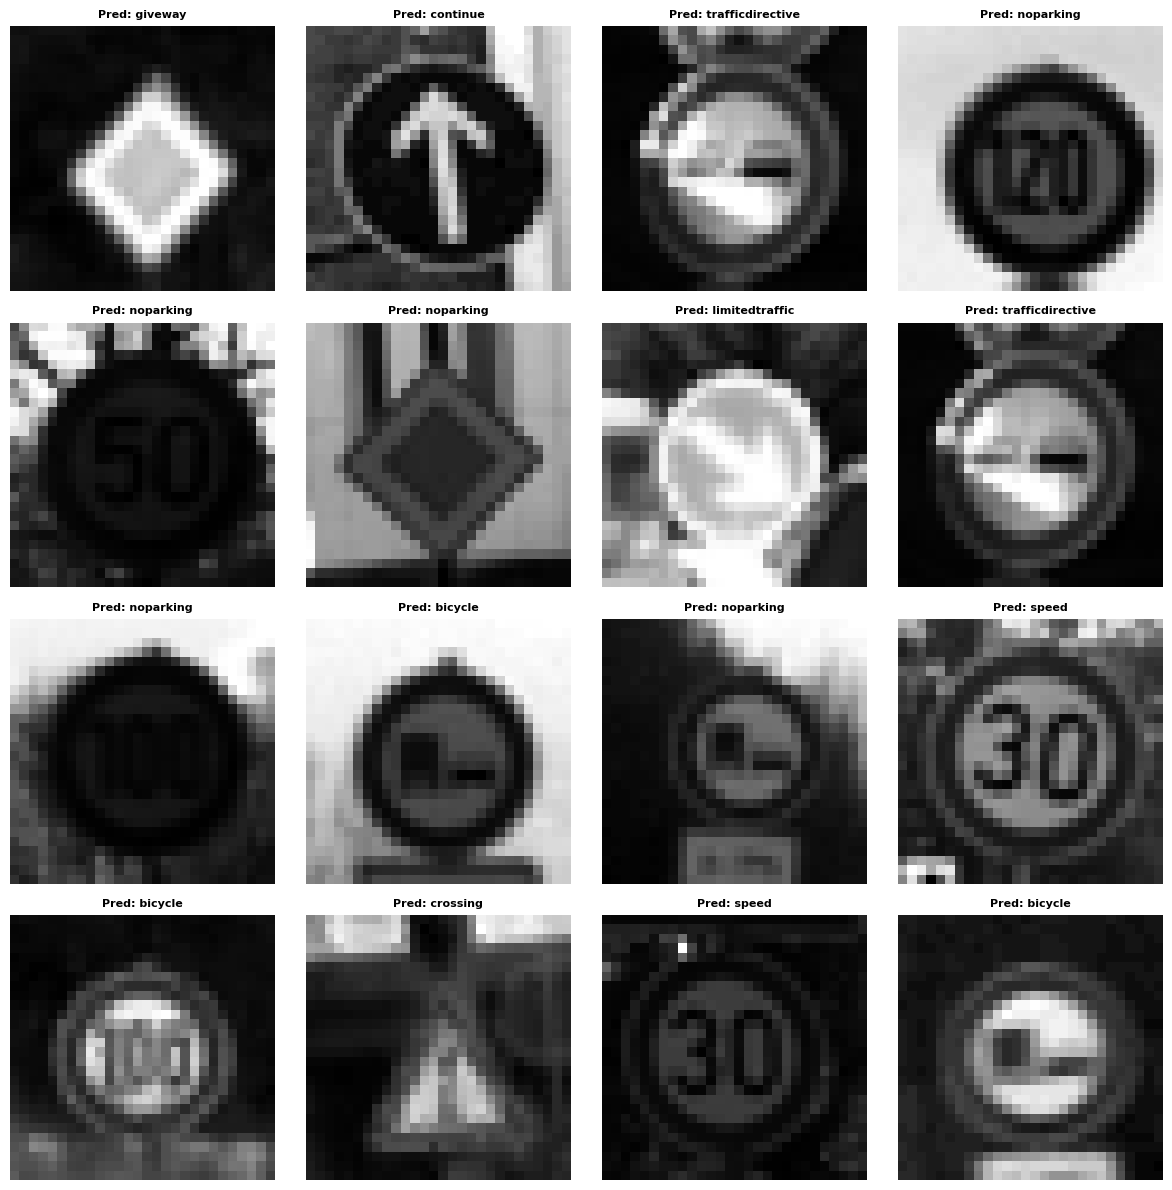

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 28, 16)          │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         803,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,352 (4.36 MB)

 Trainable params: 1,142,096 (4.36 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - loss: 1.7511 - sparse_categorical_accuracy: 0.5069 - val_loss: 2.7493 - val_sparse_categorical_accuracy: 0.1767
Epoch 2/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.4743 - sparse_categorical_accuracy: 0.8720 - val_loss: 2.7238 - val_sparse_categorical_accuracy: 0.1289
Epoch 3/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.2381 - sparse_categorical_accuracy: 0.9372 - val_loss: 2.4872 - val_sparse_categorical_accuracy: 0.2574
Epoch 4/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.1121 - sparse_categorical_accuracy: 0.9760 - val_loss: 1.9327 - val_sparse_categorical_accuracy: 0.4874
Epoch 5/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.0530 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.8100
Epoch 6/25
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.4874 - val_sparse_categorical_accuracy: 0.867

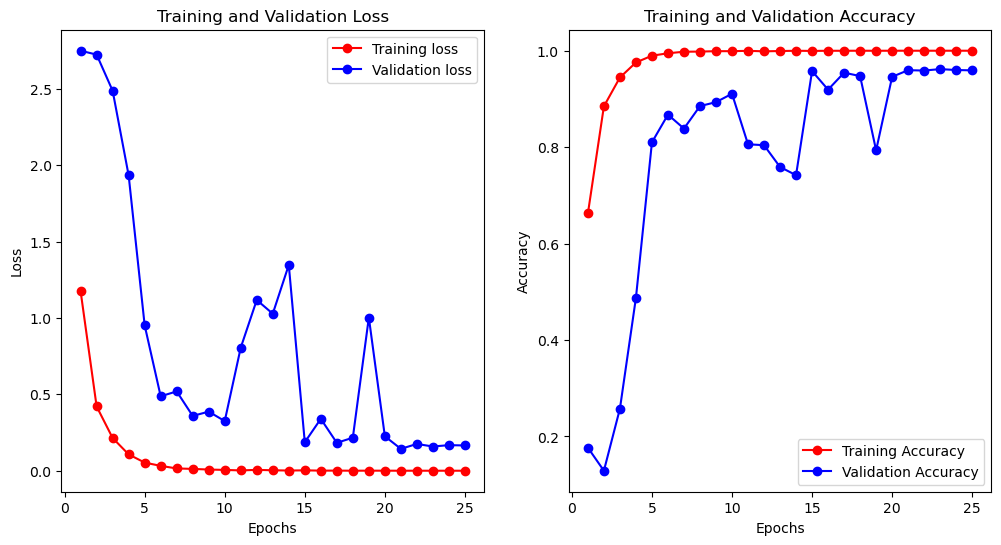

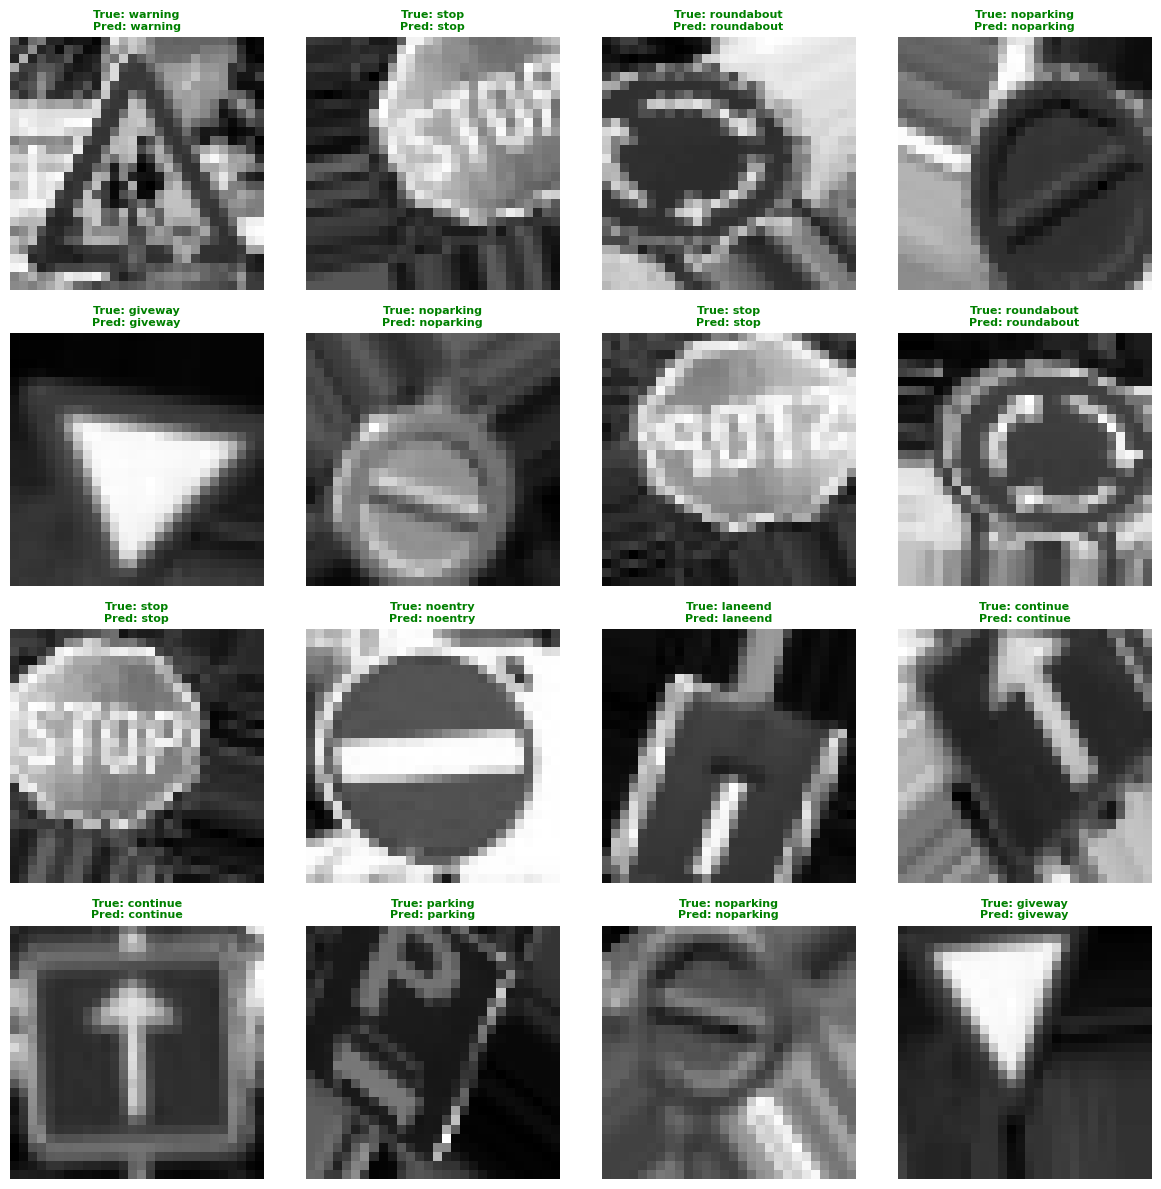

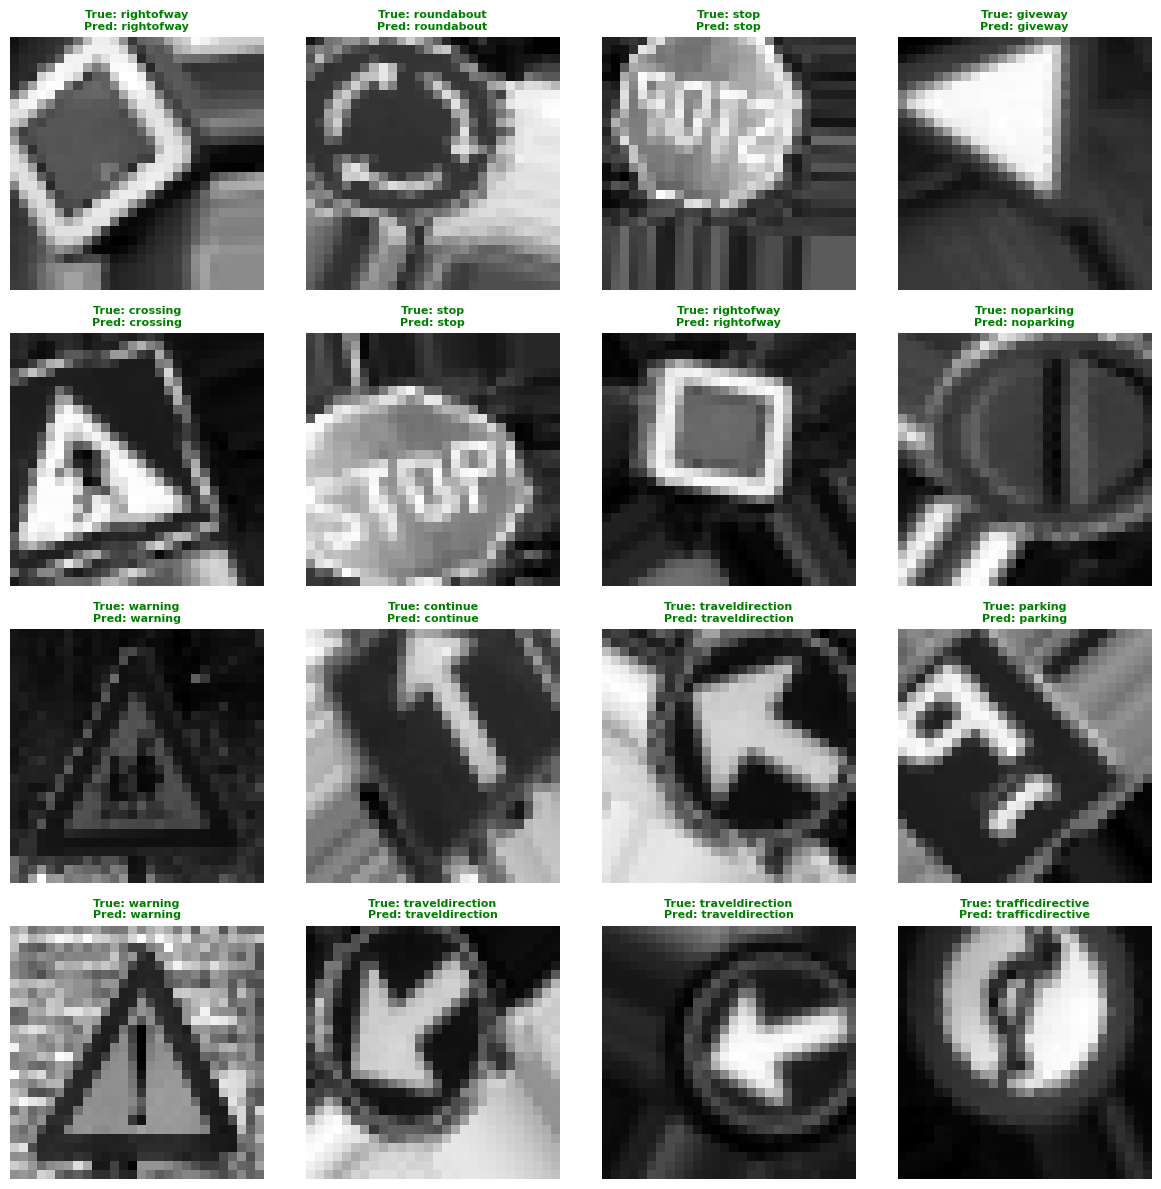

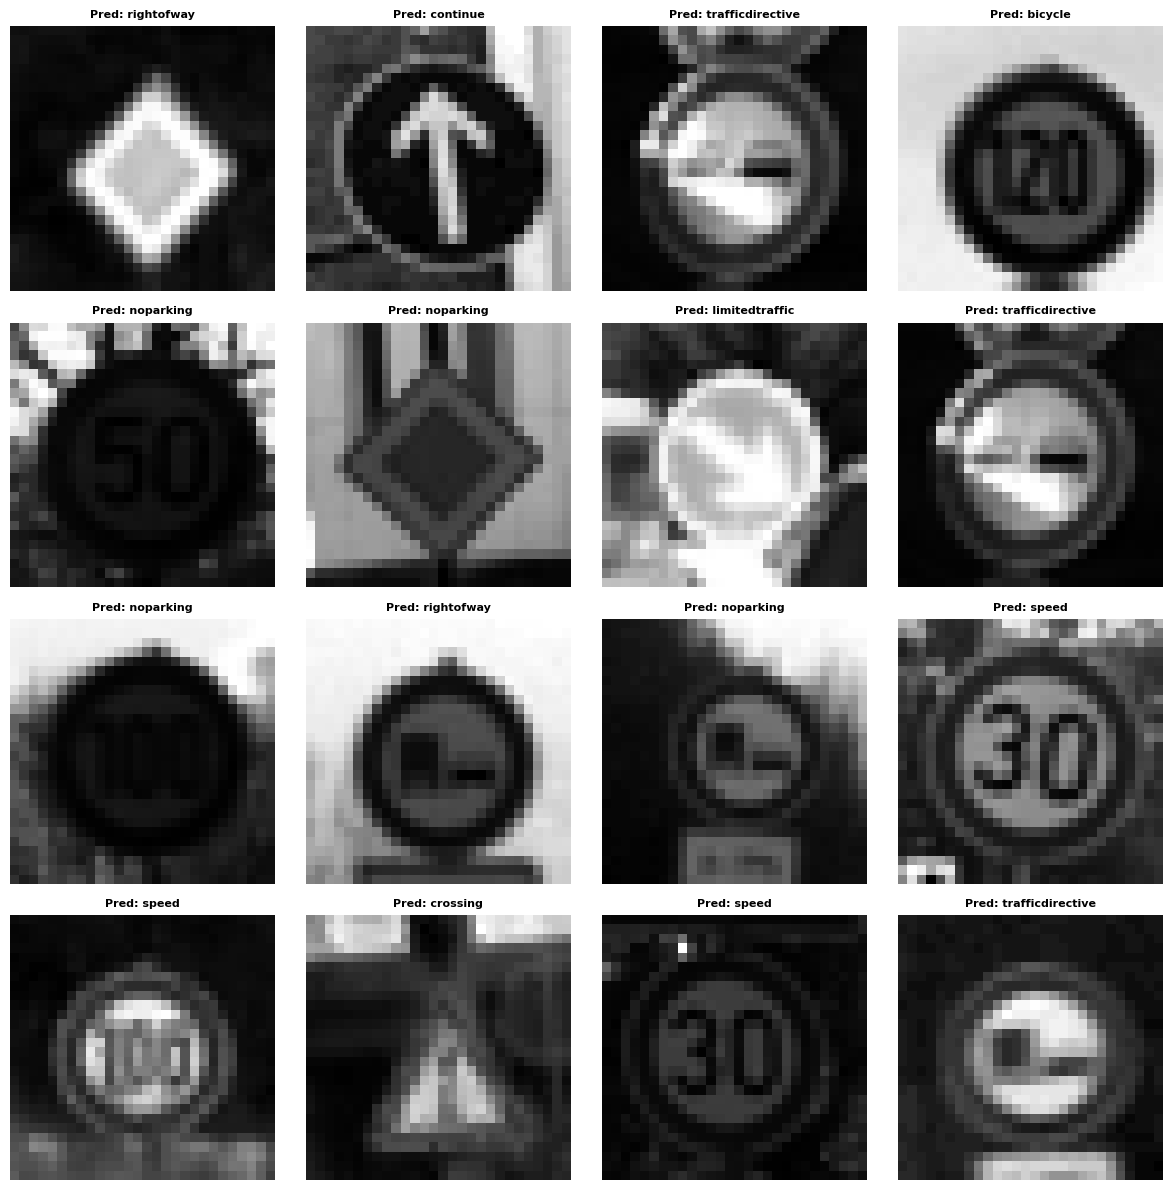

In [9]:
# Iterate through each model
for target_model in NeuralNetwork_models:
    target_model.compile(
        optimizer=RMSprop(learning_rate = 1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )

    target_model.summary()

    hist = target_model.fit(
        train,
        epochs=25,
        batch_size=64,
        validation_data=val
    )

    # Plot the learning curve
    plot_learning_curve(hist)

    # Evaluate the model
    vResults_tf(target_model, val, data.class_names)
    vResults_tf(target_model, test, data.class_names)
    vResults_raw(target_model, raw_data, data.class_names)